In [2]:
#We load in the specific data needed
import polars as pl
import numpy as np
import os
from pathlib import Path
import pandas as pd
from datetime import date
import datetime
import hvplot.polars
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import bisplrep, bisplev
from datetime import timedelta
from patsy import dmatrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV


In [3]:
tot_data_train_c = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/tech_data/data_set_train_val_tech_scaled_c.parquet')
tot_data_train_p = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/tech_data/data_set_train_val_tech_scaled_p.parquet')

data_test_p = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/tech_data/data_set_test_tech_scaled_p_total.parquet')
data_test_c = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/tech_data/data_set_test_tech_scaled_c_total.parquet')

# firm_data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Firm_variables/daily_firm_data_median_new.parquet')

data_test = pd.concat([data_test_p, data_test_c], axis=0)
data_train_tot = pd.concat([tot_data_train_c, tot_data_train_p], axis=0)

# # List of columns to drop
data_test = pd.concat([data_test_p, data_test_c], axis=0)
data_train_tot = pd.concat([tot_data_train_p, tot_data_train_c], axis=0)

# List of columns to drop
columns_to_drop = ['moneyness_squared_mean', 'moneyness_group', 'tau_squared_mean', 'moneyness_tau_mean', 'tau_squared_std', 'moneyness_tau_std', 'T_std', 'impl_volatility_std', 'moneyness_squared_std']
# columns_to_drop = ['trading_days_till_exp']

# Drop columns from datasets if they exist
# data_train = data_train.drop(columns=columns_to_drop, errors='ignore')
# data_val = data_val.drop(columns=columns_to_drop, errors='ignore')
data_test = data_test.drop(columns=columns_to_drop, errors='ignore')
data_train_tot = data_train_tot.drop(columns=columns_to_drop, errors='ignore')

data_test = data_test[data_test['impl_volatility_mean'] != 0]
data_train_tot = data_train_tot[data_train_tot['impl_volatility_mean'] != 0]

data_train_tot_c = data_train_tot[data_train_tot['cp_flag'] == 'C']
data_train_tot_p = data_train_tot[data_train_tot['cp_flag'] == 'P']

# top_features_c = ['cp_flag', 'Ticker', 'date', 'impl_volatility', 'prev_day_iv', 'T', 'prev2_day_iv', 'BIDLO', 'OPEN_vix','hi-lo_stock','FF_rate', 'gold_price', 'reces_indi', 'cumulative_return','spread_vix', 'vol_stock','5_day_rolling_return_stock','spread_stock','1Y_bond','CLOSE_vix','RET','moneyness','10Y_RIR' ]
# top_features_p = ['cp_flag', 'Ticker', 'date', 'impl_volatility', 'prev_day_iv', 'T', 'prev2_day_iv', 'cumulative_return', 'gold_price', 'reces_indi','FF_rate','hi-lo_stock', 'PRC_actual' , 'CLOSE_vix' ]

# data_train_tot_c = tot_data_train[tot_data_train['cp_flag'] == 'C'][top_features_c]
# data_train_tot_p = tot_data_train[tot_data_train['cp_flag'] == 'P'][top_features_p]



data_train_tot_c



,date,moneyness_mean,moneyness_std,impl_volatility_mean,T_mean,volume_option_mean,volume_option_std,spread_option_mean,spread_option_std,prc_option_mean,...,cp_flag,FF_rate,gold_price,reces_indi,10Y_RIR,1Y_bond,2Y_bond,OPEN_vix,CLOSE_vix,hi-lo_vix
10,2019-01-02,-1.559693,-0.899796,0.487425,-0.000623,-0.892034,-0.775850,1.931987,2.002133,1.143992,...,C,1.126349,-1.357150,-0.709812,1.566975,1.374613,1.472822,0.677893,0.478375,-0.134139
11,2019-01-02,-1.238194,0.280259,0.480363,-0.000623,-0.672816,-0.593749,0.841789,1.048057,0.555735,...,C,1.126349,-1.357150,-0.709812,1.566975,1.374613,1.472822,0.677893,0.478375,-0.134139
12,2019-01-02,-0.862361,-0.483196,0.484917,-0.000623,-0.541080,-0.462838,0.101784,0.096188,0.303572,...,C,1.126349,-1.357150,-0.709812,1.566975,1.374613,1.472822,0.677893,0.478375,-0.134139
13,2019-01-02,-0.517492,0.095575,0.495387,-0.000623,-0.526974,-0.629729,-0.087657,-0.114131,0.039180,...,C,1.126349,-1.357150,-0.709812,1.566975,1.374613,1.472822,0.677893,0.478375,-0.134139
14,2019-01-02,-0.154267,-0.016268,0.485254,-0.000623,-0.392774,-0.166903,-0.229368,-0.170793,-0.190332,...,C,1.126349,-1.357150,-0.709812,1.566975,1.374613,1.472822,0.677893,0.478375,-0.134139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5035,2020-12-31,0.116888,0.118652,0.376182,-1.520941,4.338761,3.741729,-0.552380,-0.544018,-0.497352,...,C,-1.162816,1.436988,0.268241,-0.801314,-1.215175,-1.208572,-0.056028,-0.033654,-0.552581
5036,2020-12-31,0.514576,0.449081,0.378704,-1.520941,4.850644,6.542937,-0.596780,-0.608031,-0.545443,...,C,-1.162816,1.436988,0.268241,-0.801314,-1.215175,-1.208572,-0.056028,-0.033654,-0.552581
5037,2020-12-31,0.858547,-6.472006,0.389960,-1.520941,2.451356,2.170486,-0.626380,-0.608329,-0.584979,...,C,-1.162816,1.436988,0.268241,-0.801314,-1.215175,-1.208572,-0.056028,-0.033654,-0.552581
5038,2020-12-31,1.192630,1.742726,0.378551,-1.520941,0.689877,0.521470,-0.612320,-0.601425,-0.585851,...,C,-1.162816,1.436988,0.268241,-0.801314,-1.215175,-1.208572,-0.056028,-0.033654,-0.552581


In [65]:
# import numpy as np
# import tensorflow as tf
# from scikeras.wrappers import KerasRegressor
# from sklearn.inspection import permutation_importance
# import pandas as pd
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# # Set random seeds for reproducibility
# def set_random_seed(seed=42):
#     np.random.seed(seed)
#     tf.random.set_seed(seed)

# def build_nn(input_shape, **kwargs):
#     model = Sequential()
#     model.add(Dense(64, input_dim=input_shape, activation='relu'))
#     model.add(Dense(32, activation='relu'))
#     model.add(Dense(1))  # Single output for regression task
    
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

# def feature_permutation_importance_nn(train_data, verbose=True):
#     set_random_seed(42)  # Ensure the seed is set before training
    
#     X_train = train_data.drop(columns=['impl_volatility', 'date', 'Ticker', 'cp_flag'])  # Drop unwanted columns
#     y_train = train_data['impl_volatility']  # Target variable (implied volatility)

#     # Wrapping the Keras model with KerasRegressor
#     nn_model = KerasRegressor(model=build_nn, input_shape=X_train.shape[1], verbose=0)

#     if verbose:
#         print("Training Neural Network model...")

#     # Fit the NN model
#     nn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    
#     # Perform permutation importance
#     perm_importance = permutation_importance(
#         estimator=nn_model, 
#         X=X_train, 
#         y=y_train, 
#         n_repeats=10, 
#         random_state=42,  # Ensure random_state for permutation importance is set
#         scoring='r2'
#     )

#     # Create a DataFrame for feature importances
#     feature_importances = pd.DataFrame({
#         'Feature': X_train.columns,
#         'Importance': perm_importance.importances_mean,
#         'Importance_std': perm_importance.importances_std
#     })

#     # Extract and return feature importances
#     feature_importances = pd.Series(nn_model.feature_importances_, index=X_train.columns)
#     return feature_importances

#     # feature_importances = feature_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)
#     # return feature_importances

# # Call options feature importance
# print("Evaluating features for Call options (NN model)...")
# feature_importances_call_nn = feature_permutation_importance_nn(data_train_tot_c, verbose=True)
# print(feature_importances_call_nn)

# # Put options feature importance
# print("\nEvaluating features for Put options (NN model)...")
# feature_importances_put_nn = feature_permutation_importance_nn(data_train_tot_p, verbose=True)
# print(feature_importances_put_nn)


In [5]:
data_train_tot_c

,date,moneyness_mean,moneyness_std,impl_volatility_mean,T_mean,volume_option_mean,volume_option_std,spread_option_mean,spread_option_std,prc_option_mean,...,cp_flag,FF_rate,gold_price,reces_indi,10Y_RIR,1Y_bond,2Y_bond,OPEN_vix,CLOSE_vix,hi-lo_vix
10,2019-01-02,-1.559693,-0.899796,0.487425,-0.000623,-0.892034,-0.775850,1.931987,2.002133,1.143992,...,C,1.126349,-1.357150,-0.709812,1.566975,1.374613,1.472822,0.677893,0.478375,-0.134139
11,2019-01-02,-1.238194,0.280259,0.480363,-0.000623,-0.672816,-0.593749,0.841789,1.048057,0.555735,...,C,1.126349,-1.357150,-0.709812,1.566975,1.374613,1.472822,0.677893,0.478375,-0.134139
12,2019-01-02,-0.862361,-0.483196,0.484917,-0.000623,-0.541080,-0.462838,0.101784,0.096188,0.303572,...,C,1.126349,-1.357150,-0.709812,1.566975,1.374613,1.472822,0.677893,0.478375,-0.134139
13,2019-01-02,-0.517492,0.095575,0.495387,-0.000623,-0.526974,-0.629729,-0.087657,-0.114131,0.039180,...,C,1.126349,-1.357150,-0.709812,1.566975,1.374613,1.472822,0.677893,0.478375,-0.134139
14,2019-01-02,-0.154267,-0.016268,0.485254,-0.000623,-0.392774,-0.166903,-0.229368,-0.170793,-0.190332,...,C,1.126349,-1.357150,-0.709812,1.566975,1.374613,1.472822,0.677893,0.478375,-0.134139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5035,2020-12-31,0.116888,0.118652,0.376182,-1.520941,4.338761,3.741729,-0.552380,-0.544018,-0.497352,...,C,-1.162816,1.436988,0.268241,-0.801314,-1.215175,-1.208572,-0.056028,-0.033654,-0.552581
5036,2020-12-31,0.514576,0.449081,0.378704,-1.520941,4.850644,6.542937,-0.596780,-0.608031,-0.545443,...,C,-1.162816,1.436988,0.268241,-0.801314,-1.215175,-1.208572,-0.056028,-0.033654,-0.552581
5037,2020-12-31,0.858547,-6.472006,0.389960,-1.520941,2.451356,2.170486,-0.626380,-0.608329,-0.584979,...,C,-1.162816,1.436988,0.268241,-0.801314,-1.215175,-1.208572,-0.056028,-0.033654,-0.552581
5038,2020-12-31,1.192630,1.742726,0.378551,-1.520941,0.689877,0.521470,-0.612320,-0.601425,-0.585851,...,C,-1.162816,1.436988,0.268241,-0.801314,-1.215175,-1.208572,-0.056028,-0.033654,-0.552581


In [67]:
# from scikeras.wrappers import KerasRegressor
# from sklearn.inspection import permutation_importance
# import pandas as pd
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# def build_nn(input_dim, **kwargs):
#     model = Sequential()
#     model.add(Dense(64, input_dim=input_dim, activation='relu'))
#     model.add(Dense(32, activation='relu'))
#     model.add(Dense(1))  # Single output for regression task
    
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model


# def feature_permutation_importance_nn(train_data, verbose=True):
#     X_train = train_data.drop(columns=['impl_volatility', 'date', 'Ticker', 'cp_flag'])  # Drop unwanted columns
#     y_train = train_data['impl_volatility']  # Target variable (implied volatility)

#     # Wrapping the Keras model with KerasRegressor
#     nn_model = KerasRegressor(model=build_nn, input_dim=X_train.shape[1], verbose=0)

#     if verbose:
#         print("Training Neural Network model for Call options...")

#     # Fit the NN model
#     nn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    
#     # Perform permutation importance
#     perm_importance = permutation_importance(
#         estimator=nn_model, 
#         X=X_train, 
#         y=y_train, 
#         n_repeats=10, 
#         random_state=42, 
#         scoring='r2'
#     )

#     # Create a DataFrame for feature importances
#     feature_importances = pd.DataFrame({
#         'Feature': X_train.columns,
#         'Importance': perm_importance.importances_mean,
#         'Importance_std': perm_importance.importances_std
#     })

#     feature_importances = feature_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)
#     return feature_importances

# # Call options feature importance
# print("Evaluating features for Call options (NN model)...")
# feature_importances_call_nn = feature_permutation_importance_nn(data_train_tot_c, verbose=True)
# print(feature_importances_call_nn)

# # Put options feature importance
# print("\nEvaluating features for Put options (NN model)...")
# feature_importances_put_nn = feature_permutation_importance_nn(data_train_tot_p, verbose=True)
# print(feature_importances_put_nn)



In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def build_nn(input_shape):
    """
    Build a simple Neural Network model using Keras.
    
    Parameters:
    - input_shape (int): Number of input features.
    
    Returns:
    - model: Compiled Neural Network model.
    """
    model = Sequential()
    model.add(Dense(64, input_dim=input_shape, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Single output for regression task
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def feature_permutation_importance_nn(train_data, verbose=True):
    """
    Perform permutation importance for a Neural Network on the training data to identify the top features.
    
    Parameters:
    - train_data (pd.DataFrame): The training dataset.
    - verbose (bool): If True, prints progress information.
    
    Returns:
    - feature_importances (pd.DataFrame): A dataframe containing feature names and their importance.
    """
    # Prepare the train data
    X_train = train_data.drop(columns=['impl_volatility_mean', 'date', 'cp_flag'])  # Drop unwanted columns
    y_train = train_data['impl_volatility_mean']  # Target variable (implied volatility)

    # Build and train the Neural Network model
    nn_model = build_nn(X_train.shape[1])
    
    if verbose:
        print("Training Neural Network model...")

    # Fit the NN model (with verbose = 0 to avoid too much output)
    nn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    
    # Perform permutation importance using the custom prediction function
    perm_importance = permutation_importance(
        estimator=nn_model, 
        X=X_train, 
        y=y_train, 
        n_repeats=10, 
        random_state=42, 
        scoring='r2'
    )

    # Create a DataFrame for feature importances
    feature_importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': perm_importance.importances_mean,
        'Importance_std': perm_importance.importances_std
    })

    # Sort by importance
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    return feature_importances

# Call options
print("Evaluating features for Call options (NN model)...")
feature_importances_call_nn = feature_permutation_importance_nn(data_train_tot_c, verbose=True)
# selected_features_call_nn = select_top_features(feature_importances_call_nn, threshold=0.85)

# Put options
print("\nEvaluating features for Put options (NN model)...")
feature_importances_put_nn = feature_permutation_importance_nn(data_train_tot_p, verbose=True)
# selected_features_put_nn = select_top_features(feature_importances_put_nn, threshold=0.85)



Evaluating features for Call options (NN model)...
Training Neural Network model...


/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
158/158 ━━━

/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
158/158 ━━━

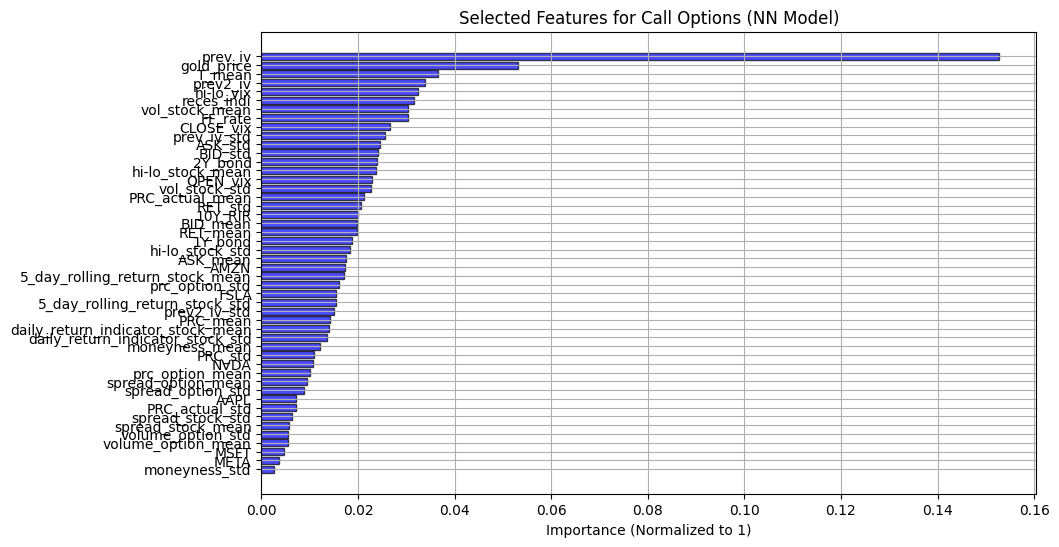

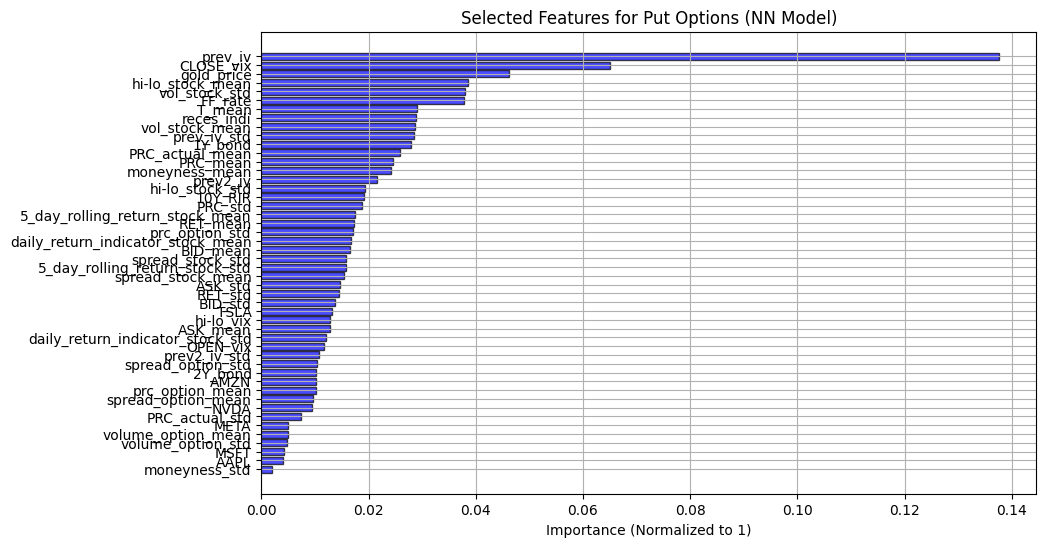

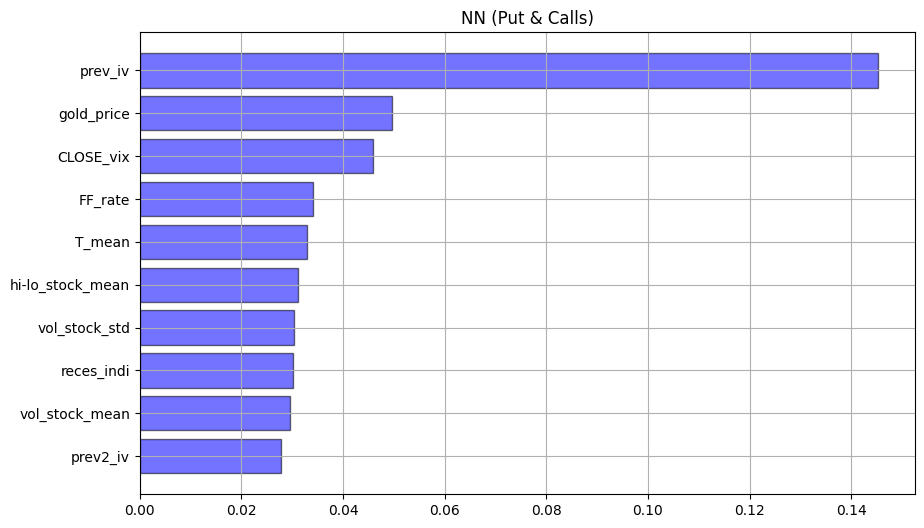

In [9]:
def select_top_features(feature_importances, top_n=10):
    """
    Select the top N features based on importance.
    
    Parameters:
    - feature_importances (pd.DataFrame): A dataframe containing feature names and their importance.
    - top_n (int): Number of top features to select.
    
    Returns:
    - selected_features (pd.DataFrame): A dataframe with the selected features and their importance.
    """
    # Select the top N features
    selected_features = feature_importances.iloc[:top_n].copy()

    # Normalize the selected features' importance so that they sum to 1
    selected_features['Importance'] /= selected_features['Importance'].sum()

    return selected_features

selected_features_call_nn = select_top_features(feature_importances_call_nn, top_n=50)
selected_features_put_nn = select_top_features(feature_importances_put_nn, top_n=50)

# Plot Feature Importance for the top selected features
def plot_feature_importance(feature_importances, title):
    """
    Plot the feature importance.
    
    Parameters:
    - feature_importances (pd.DataFrame): Feature importance dataframe.
    - title (str): Title for the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='blue', alpha=0.7, edgecolor='black')
    plt.xlabel('Importance (Normalized to 1)')
    plt.title(title)
    plt.gca().invert_yaxis()  # Reverse order for better readability
    plt.grid(True)
    plt.show()

# Plot the selected features for Call and Put options
plot_feature_importance(selected_features_call_nn, "Selected Features for Call Options (NN Model)")
plot_feature_importance(selected_features_put_nn, "Selected Features for Put Options (NN Model)")

# Average Feature Importance for Calls and Puts
def average_feature_importance(feature_importance_call, feature_importance_put):
    """
    Calculate the average feature importance for Calls and Puts and plot the average features.
    
    Parameters:
    - feature_importance_call (pd.DataFrame): Feature importance for Call options.
    - feature_importance_put (pd.DataFrame): Feature importance for Put options.
    """
    # Merge call and put feature importance
    combined_importance = pd.merge(feature_importance_call[['Feature', 'Importance']],
                                   feature_importance_put[['Feature', 'Importance']],
                                   on='Feature', how='outer', suffixes=('_call', '_put')).fillna(0)

    # Calculate average importance
    combined_importance['Average'] = (combined_importance['Importance_call'] + combined_importance['Importance_put']) / 2

    # Normalize the average importance so they sum to 1
    combined_importance['Average'] /= combined_importance['Average'].sum()

    # Sort by average importance and plot
    combined_importance = combined_importance.sort_values(by='Average', ascending=False).head(10)

    # Plot the average feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(combined_importance['Feature'], combined_importance['Average'], color='Blue', alpha=0.55, edgecolor='black')
    # plt.xlabel('Average Importance (Normalized to 1)')
    plt.title("NN (Put & Calls)")
    plt.gca().invert_yaxis()  # Reverse order for better readability
    plt.grid(True)
    plt.show()

    return combined_importance

# Plot the average feature importance for Calls and Puts
avg_featimport = average_feature_importance(selected_features_call_nn, selected_features_put_nn)

In [43]:
avg_featimport

,Feature,Importance_call,Importance_put,Average
10,prev_day_iv,0.249665,0.306055,0.277860
2,FF_rate,0.128674,0.123391,0.126032
11,reces_indi,0.087864,0.100107,0.093985
9,prev2_day_iv,0.071578,0.102666,0.087122
7,gold_price,0.070516,0.072661,0.071589
5,T,0.069011,0.071345,0.070178
8,hi-lo_stock,0.077270,0.054480,0.065875
3,OPEN_vix,0.097286,0.000000,0.048643
12,spread_vix,0.077726,0.000000,0.038863
0,BIDLO,0.070411,0.000000,0.035205


In [56]:
selected_features_call_nn

,Feature,Importance,Importance_std
0,prev_day_iv,0.249665,0.005350
1,FF_rate,0.128674,0.003608
2,OPEN_vix,0.097286,0.002761
3,reces_indi,0.087864,0.002408
4,spread_vix,0.077726,0.002712
5,hi-lo_stock,0.077270,0.002896
6,prev2_day_iv,0.071578,0.001803
7,gold_price,0.070516,0.002149
8,BIDLO,0.070411,0.002673
9,T,0.069011,0.003905


In [175]:
# # Top features for Call and Put options
# top_features_c = ['cp_flag', 'Ticker', 'date', 'impl_volatility', 'prev_day_iv', 'T', 'prev2_day_iv', 'BIDLO', 'OPEN_vix'] used first
# top_features_c = ['cp_flag', 'Ticker', 'date', 'impl_volatility', 'prev_day_iv', 'T', 'prev2_day_iv','gold_price', 'hi-lo_stock']
# top_features_p = ['cp_flag', 'Ticker', 'date', 'impl_volatility', 'prev_day_iv', 'T', 'vol_stock', 'prev2_day_iv', 'hi-lo_stock', '5_day_rolling_return_stock']
# top_features_p = ['cp_flag', 'Ticker', 'date', 'impl_volatility', 'prev_day_iv', 'T', 'prev2_day_iv', 'cumulative_return', 'BIDLO'] used first


# top_features_c = ['cp_flag', 'Tiker', 'date', 'impl_volatilicker', 'date', 'impl_volatility', 'prev_day_iv', 'T', 'prev2_day_iv', 'BIDLO', 'OPEN_vix','hi-lo_stock','FF_rate', 'gold_price', 'reces_indi','spread_vix' ]
# top_features_p = ['cp_flag', 'Ticty', 'prev_day_iv', 'T', 'prev2_day_iv', 'cumulative_return', 'gold_price', 'reces_indi','FF_rate','hi-lo_stock', 'PRC_actual' , 'CLOSE_vix' ]


# # Prepare train data for Call and Put options
# data_train_c = data_train[data_train['cp_flag'] == 'C'][top_features_c]
# data_train_p = data_train[data_train['cp_flag'] == 'P'][top_features_p]

# # Prepare validation data for Call and Put options
# data_validate_c = data_val[data_val['cp_flag'] == 'C'][top_features_c]
# data_validate_p = data_val[data_val['cp_flag'] == 'P'][top_features_p]

# # Prepare the total train data for Call and Put options
# data_train_tot_c = tot_data_train[tot_data_train['cp_flag'] == 'C'][top_features_c]
# data_train_tot_p = tot_data_train[tot_data_train['cp_flag'] == 'P'][top_features_p]

# # Prepare test data for Call and Put options
# data_test_c = data_test[data_test['cp_flag'] == 'C'][top_features_c]
# data_test_p = data_test[data_test['cp_flag'] == 'P'][top_features_p]

# # Prepare the total train data for Call and Put options
# data_train_tot_c = tot_data_train[tot_data_train['cp_flag'] == 'C']
# data_train_tot_p = tot_data_train[tot_data_train['cp_flag'] == 'P']

# # Prepare test data for Call and Put options
# data_test_c = data_test[data_test['cp_flag'] == 'C']
# data_test_p = data_test[data_test['cp_flag'] == 'P']

In [10]:
# # Prepare the total train data for Call and Put options
# data_train_tot_c = tot_data_train[tot_data_train['cp_flag'] == 'C']
# data_train_tot_p = tot_data_train[tot_data_train['cp_flag'] == 'P']

# Prepare test data for Call and Put options
data_test_c = data_test[data_test['cp_flag'] == 'C']
data_test_p = data_test[data_test['cp_flag'] == 'P']

data_test_c

,date,cp_flag,impl_volatility_mean,moneyness_mean,moneyness_std,T_mean,volume_option_mean,volume_option_std,spread_option_mean,spread_option_std,...,prev2_iv_std,FF_rate,gold_price,reces_indi,10Y_RIR,1Y_bond,2Y_bond,OPEN_vix,CLOSE_vix,hi-lo_vix
5040,2021-01-04,C,0.479429,-1.558174,-0.573249,1.519695,-0.648503,-0.483160,0.444798,0.423291,...,-0.475013,-1.162816,1.451941,0.266074,-0.801314,-1.218487,-1.213376,-0.071108,-0.041412,-0.407989
5041,2021-01-04,C,0.479940,-1.231237,0.025769,1.519695,-0.266864,0.008727,0.324876,0.253570,...,-0.636105,-1.162816,1.451941,0.266074,-0.801314,-1.218487,-1.213376,-0.071108,-0.041412,-0.407989
5042,2021-01-04,C,0.445119,-0.875225,-0.092094,1.519695,0.878495,0.650266,-0.008032,-0.003739,...,-0.806542,-1.162816,1.451941,0.266074,-0.801314,-1.218487,-1.213376,-0.071108,-0.041412,-0.407989
5043,2021-01-04,C,0.421343,-0.519891,0.324400,1.519695,0.299428,0.104081,-0.145870,-0.095167,...,-0.835290,-1.162816,1.451941,0.266074,-0.801314,-1.218487,-1.213376,-0.071108,-0.041412,-0.407989
5044,2021-01-04,C,0.437297,-0.168351,-0.533852,1.519695,-0.213639,-0.264423,-0.123177,-0.165621,...,-0.971770,-1.162816,1.451941,0.266074,-0.801314,-1.218487,-1.213376,-0.071108,-0.041412,-0.407989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7535,2021-12-30,C,0.397993,0.168960,-0.803586,-0.760782,1.305590,1.189302,-0.494659,-0.568396,...,-0.052023,-1.172726,0.958946,-0.822889,0.047437,-0.812020,-0.455627,-0.568767,-0.630316,-0.381699
7536,2021-12-30,C,0.458480,0.508151,-0.739018,-0.760782,1.292262,1.155390,-0.587900,-0.589187,...,-0.094125,-1.172726,0.958946,-0.822889,0.047437,-0.812020,-0.455627,-0.568767,-0.630316,-0.381699
7537,2021-12-30,C,0.438479,0.877727,1.205688,-0.760782,-0.290051,-0.549276,-0.577244,-0.612072,...,-0.005873,-1.172726,0.958946,-0.822889,0.047437,-0.812020,-0.455627,-0.568767,-0.630316,-0.381699
7538,2021-12-30,C,0.497671,1.216140,-2.082956,-0.760782,0.998866,1.236708,-0.610988,-0.588507,...,0.169813,-1.172726,0.958946,-0.822889,0.047437,-0.812020,-0.455627,-0.568767,-0.630316,-0.381699


In [11]:
# Prepare train, validation, and test data for Call options
# train_x_c = data_train_c.drop(columns=['impl_volatility', 'date', 'Ticker', 'cp_flag'])
# train_y_c = data_train_c['impl_volatility']

# validate_x_c = data_validate_c.drop(columns=['impl_volatility', 'date', 'Ticker', 'cp_flag'])
# validate_y_c = data_validate_c['impl_volatility']

combined_x_c = data_train_tot_c.drop(columns=['impl_volatility_mean', 'date', 'cp_flag'])
combined_y_c = data_train_tot_c['impl_volatility_mean']

test_x_c = data_test_c.drop(columns=['impl_volatility_mean', 'date', 'cp_flag'])
test_y_c = data_test_c['impl_volatility_mean']

# Prepare train, validation, and test data for Put options
# train_x_p = data_train_p.drop(columns=['impl_volatility', 'date', 'Ticker', 'cp_flag'])
# train_y_p = data_train_p['impl_volatility']

# validate_x_p = data_validate_p.drop(columns=['impl_volatility', 'date', 'Ticker', 'cp_flag'])
# validate_y_p = data_validate_p['impl_volatility']

combined_x_p = data_train_tot_p.drop(columns=['impl_volatility_mean', 'date', 'cp_flag'])
combined_y_p = data_train_tot_p['impl_volatility_mean']

test_x_p = data_test_p.drop(columns=['impl_volatility_mean', 'date', 'cp_flag'])
test_y_p = data_test_p['impl_volatility_mean']

In [12]:
test_x_c

,moneyness_mean,moneyness_std,T_mean,volume_option_mean,volume_option_std,spread_option_mean,spread_option_std,prc_option_mean,prc_option_std,PRC_mean,...,prev2_iv_std,FF_rate,gold_price,reces_indi,10Y_RIR,1Y_bond,2Y_bond,OPEN_vix,CLOSE_vix,hi-lo_vix
5040,-1.558174,-0.573249,1.519695,-0.648503,-0.483160,0.444798,0.423291,1.560488,1.066929,1.244845,...,-0.475013,-1.162816,1.451941,0.266074,-0.801314,-1.218487,-1.213376,-0.071108,-0.041412,-0.407989
5041,-1.231237,0.025769,1.519695,-0.266864,0.008727,0.324876,0.253570,0.998968,0.624974,1.124845,...,-0.636105,-1.162816,1.451941,0.266074,-0.801314,-1.218487,-1.213376,-0.071108,-0.041412,-0.407989
5042,-0.875225,-0.092094,1.519695,0.878495,0.650266,-0.008032,-0.003739,0.473121,0.300945,1.218837,...,-0.806542,-1.162816,1.451941,0.266074,-0.801314,-1.218487,-1.213376,-0.071108,-0.041412,-0.407989
5043,-0.519891,0.324400,1.519695,0.299428,0.104081,-0.145870,-0.095167,0.139564,0.068362,1.467864,...,-0.835290,-1.162816,1.451941,0.266074,-0.801314,-1.218487,-1.213376,-0.071108,-0.041412,-0.407989
5044,-0.168351,-0.533852,1.519695,-0.213639,-0.264423,-0.123177,-0.165621,-0.060525,-0.163955,1.316600,...,-0.971770,-1.162816,1.451941,0.266074,-0.801314,-1.218487,-1.213376,-0.071108,-0.041412,-0.407989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7535,0.168960,-0.803586,-0.760782,1.305590,1.189302,-0.494659,-0.568396,-0.490883,-0.562857,1.546873,...,-0.052023,-1.172726,0.958946,-0.822889,0.047437,-0.812020,-0.455627,-0.568767,-0.630316,-0.381699
7536,0.508151,-0.739018,-0.760782,1.292262,1.155390,-0.587900,-0.589187,-0.549189,-0.566990,2.506755,...,-0.094125,-1.172726,0.958946,-0.822889,0.047437,-0.812020,-0.455627,-0.568767,-0.630316,-0.381699
7537,0.877727,1.205688,-0.760782,-0.290051,-0.549276,-0.577244,-0.612072,-0.555250,-0.599648,3.664669,...,-0.005873,-1.172726,0.958946,-0.822889,0.047437,-0.812020,-0.455627,-0.568767,-0.630316,-0.381699
7538,1.216140,-2.082956,-0.760782,0.998866,1.236708,-0.610988,-0.588507,-0.580448,-0.596725,1.548882,...,0.169813,-1.172726,0.958946,-0.822889,0.047437,-0.812020,-0.455627,-0.568767,-0.630316,-0.381699


In [49]:
# import numpy as np
# import keras.backend as K
# from keras import regularizers
# from keras.layers import Dense, Dropout
# from keras.models import Sequential
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error, r2_score
# from scikeras.wrappers import KerasRegressor  # Use SciKeras instead
# from keras.optimizers import RMSprop

# # Define the model function with variable neurons, layers, and dropout rate
# def create_model(neurons=32, layers=1, dropout_rate=0.0, bias=0.01, activity=0.01):
#     model = Sequential()
#     # Input layer (first hidden layer)
#     model.add(Dense(neurons, activation='relu', input_dim=train_x.shape[1],
#                     bias_regularizer=regularizers.L2(bias),
#                     activity_regularizer=regularizers.L2(activity)))
#     model.add(Dropout(dropout_rate))  # Dropout layer after the first hidden layer

#     # Additional hidden layers
#     for _ in range(layers - 1):
#         model.add(Dense(neurons, activation='relu',
#                         bias_regularizer=regularizers.L2(bias),
#                         activity_regularizer=regularizers.L2(activity)))
#         model.add(Dropout(dropout_rate))

#     # Output layer
#     model.add(Dense(1, activation='linear'))  # Output layer for regression (linear)

#     # Compile the model
#     model.compile(optimizer=RMSprop(learning_rate=0.01),
#                   loss='mean_squared_error',
#                   metrics=['mse'])
#     return model

# # Wrapping the model in KerasRegressor
# model = KerasRegressor(build_fn=create_model, verbose=0)

# # Define the parameter grid for trials
# param_grid = {
#     'neurons': [8, 16, 32, 64],   # Number of neurons in each hidden layer
#     'layers': [1, 2, 3, 4],       # Number of hidden layers
#     'dropout_rate': [0, 0.2, 0.5], # Dropout rate
#     'batch_size': [32, 64],       # Batch size for training
#     'epochs': [50, 100],          # Number of epochs
# }

# # Function to perform hyperparameter tuning, retrain the model, and test
# def train_and_evaluate(train_x, train_y, validate_x, validate_y, combined_x, combined_y, test_x, test_y):
#     # Initialize GridSearchCV with the model, parameter grid, and scoring
#     grid_search = GridSearchCV(estimator=model,
#                                param_grid=param_grid,
#                                scoring='neg_mean_squared_error',  # Scoring based on MSE
#                                cv=3,  # 3-fold cross-validation
#                                verbose=1)  # Verbose for tracking progress

#     # Hyperparameter tuning on training and validation sets
#     print("Running hyperparameter tuning...")
#     grid_search.fit(train_x, train_y, validation_data=(validate_x, validate_y))

#     # Get the best estimator and parameters
#     best_model = grid_search.best_estimator_
#     best_params = grid_search.best_params_

#     print(f"Best Parameters: {best_params}")

#     # Retrain on the combined training and validation set
#     best_model.fit(combined_x, combined_y)

#     # Make predictions on the test set
#     predictions = best_model.predict(test_x)

#     # Calculate R² and RMSE for the best model
#     r2 = r2_score(test_y, predictions)
#     rmse = np.sqrt(mean_squared_error(test_y, predictions))

#     # Print the results
#     print(f"R²: {r2:.4f}")
#     print(f"RMSE: {rmse:.4f}")
#     return best_model

# # Call the function for Call options data
# print("\nEvaluating Call options...")
# best_model_call = train_and_evaluate(train_x_c, train_y_c, validate_x_c, validate_y_c, combined_x_c, combined_y_c, test_x_c, test_y_c)

# # Call the function for Put options data
# print("\nEvaluating Put options...")
# best_model_put = train_and_evaluate(train_x_p, train_y_p, validate_x_p, validate_y_p, combined_x_p, combined_y_p, test_x_p, test_y_p)



In [50]:
# import numpy as np
# from keras import regularizers
# from keras.layers import Dense, Dropout, Input
# from keras.models import Sequential
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error, r2_score
# from scikeras.wrappers import KerasRegressor
# from keras.optimizers import RMSprop
# import pandas as pd
# import matplotlib.pyplot as plt

# # Define the model function with variable neurons, layers, and dropout rate
# def create_model(input_dim, neurons=32, layers=1, dropout_rate=0.0):
#     model = Sequential()
#     # Input layer using Input instead of input_dim argument
#     model.add(Input(shape=(input_dim,)))  # Define the input shape explicitly

#     # First hidden layer
#     model.add(Dense(neurons, activation='relu'))
#     model.add(Dropout(dropout_rate))  # Dropout layer after the first hidden layer

#     # Additional hidden layers
#     for _ in range(layers - 1):
#         model.add(Dense(neurons, activation='relu'))
#         model.add(Dropout(dropout_rate))

#     # Output layer
#     model.add(Dense(1, activation='linear'))  # Output layer for regression (linear)

#     # Compile the model
#     model.compile(optimizer=RMSprop(learning_rate=0.0001),
#                   loss='mean_squared_error',
#                   metrics=['mse'])
#     return model

# # Wrapping the model in KerasRegressor
# def create_keras_regressor(input_dim):
#     return KerasRegressor(model=create_model, input_dim=input_dim, verbose=1)

# # Define the parameter grid for trials
# param_grid = {'batch_size': [32], 'epochs': [50], 'model__dropout_rate': [0.2], 'model__layers': [2], 'model__neurons': [64]}  # Put
# param_grid_call = {'batch_size': [32], 'epochs': [50], 'model__dropout_rate': [0.2], 'model__layers': [2], 'model__neurons': [32]}  # Call

# # Function to perform hyperparameter tuning, retrain the model, and test
# def train_and_evaluate(train_x, train_y, combined_x, combined_y, test_x, test_y, param_grid, option_type):
#     # Get input dimension from the training data
#     input_dim = combined_x.shape[1]
    
#     # Create KerasRegressor with the correct input dimension
#     model = create_keras_regressor(input_dim)

#     # Initialize GridSearchCV with the model, parameter grid, and scoring
#     grid_search = GridSearchCV(estimator=model,
#                                param_grid=param_grid,
#                                scoring='neg_mean_squared_error',
#                                verbose=3,
#                                cv=5, 
#                                n_jobs=-1)

#     # Hyperparameter tuning using validation data
#     print(f"Running hyperparameter tuning with validation data for {option_type}...")
#     grid_search.fit(combined_x, combined_y, verbose=1)

#     # Get the best estimator and parameters
#     best_model = grid_search.best_estimator_
#     best_params = grid_search.best_params_

#     print(f"Best Parameters for {option_type}: {best_params}")

#     # In-sample evaluation on the combined training and validation set
#     predictions_combined = best_model.predict(combined_x)
#     r2_combined = r2_score(combined_y, predictions_combined)
#     rmse_combined = np.sqrt(mean_squared_error(combined_y, predictions_combined))
#     print(f"In-sample R² ({option_type}): {r2_combined:.4f}")
#     print(f"In-sample RMSE ({option_type}): {rmse_combined:.4f}")

#     # Out-of-sample evaluation on the test set
#     predictions_test = best_model.predict(test_x)
#     r2_test = r2_score(test_y, predictions_test)
#     rmse_test = np.sqrt(mean_squared_error(test_y, predictions_test))
#     print(f"Out-of-sample R² ({option_type}): {r2_test:.4f}")
#     print(f"Out-of-sample RMSE ({option_type}): {rmse_test:.4f}")

#     return best_model, predictions_test

# # Extract feature importances based on model weights
# def extract_feature_importances(model, X_train, option_type):
#     """
#     Extract feature importance from the weights of the first hidden layer.
#     This is a rough approximation based on the magnitude of weights.
#     """
#     # Get the weights of the first hidden layer
#     first_layer_weights = model.model_.layers[0].get_weights()[0]

#     # Compute the importance as the sum of absolute weights across the neurons
#     feature_importances = np.sum(np.abs(first_layer_weights), axis=1)

#     # Normalize the importances so they sum to 1
#     feature_importances = feature_importances / np.sum(feature_importances)

#     # Create a pandas Series for easy handling
#     feature_importances = pd.Series(feature_importances, index=X_train.columns)
    
#     print(f"Feature importances for {option_type}:\n", feature_importances)
    
#     return feature_importances

# # Plot Feature Importance for Keras Neural Network
# def plot_feature_importance(feature_importances, option_type, top_n=5):
#     """
#     Create a bar plot showing the top N features based on Keras model weights.
#     """
#     # Select the top N features
#     top_features = feature_importances.sort_values(ascending=False).head(top_n)

#     # Plot the top N feature importances
#     plt.figure(figsize=(10, 6))
#     ax = top_features.sort_values(ascending=True).plot(kind='barh', color='blue', alpha=0.55, edgecolor='black', linewidth=1)
#     plt.grid(True)  # Add grid
#     ax.set_title(f'Top {top_n} Feature Importance ({option_type})')
#     plt.show()

# # Combine feature importances from Call and Put options and plot the top 5
# def plot_combined_feature_importance(feature_importances_call, feature_importances_put, top_n=5):
#     """
#     Create a bar plot showing the top N average feature importance of both Call and Put options.
#     """
#     # Combine the feature importances from Call and Put options
#     combined_importance = pd.concat([feature_importances_call, feature_importances_put], axis=1, keys=["Call", "Put"]).fillna(0)

#     # Calculate the average importance
#     combined_importance['Average'] = combined_importance.mean(axis=1)

#     # Select the top N features based on the average importance
#     top_features = combined_importance['Average'].sort_values(ascending=False).head(top_n)

#     # Plot the top N combined feature importance
#     plt.figure(figsize=(10, 6))
#     ax = top_features.sort_values(ascending=True).plot(kind='barh', color='blue', alpha=0.55, edgecolor='black', linewidth=1)
#     plt.grid(True)  # Add grid
#     ax.set_title('NN (Put and Call)')
#     plt.show()

# # # Example usage
# # print("\nEvaluating Call options...")
# # best_model_call, predictions_call = train_and_evaluate(train_x_c, train_y_c, combined_x_c, combined_y_c, test_x_c, test_y_c, param_grid_call, 'Call')

# # print("\nEvaluating Put options...")
# # best_model_put, predictions_put = train_and_evaluate(train_x_p, train_y_p, combined_x_p, combined_y_p, test_x_p, test_y_p, param_grid, 'Put')

# # # Extract and plot feature importance for Call options
# # feature_importances_call = extract_feature_importances(best_model_call, combined_x_c, 'Call')
# # plot_feature_importance(feature_importances_call, 'Call')

# # # Extract and plot feature importance for Put options
# # feature_importances_put = extract_feature_importances(best_model_put, combined_x_p, 'Put')
# # plot_feature_importance(feature_importances_put, 'Put')

# # # Plot combined feature importance for both Call and Put options
# # plot_combined_feature_importance(feature_importances_call, feature_importances_put, top_n=5)


In [73]:
# from sklearn.metrics import mean_squared_error
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # Function to calculate permutation importance on the training set
# def permutation_importance(model, X_train, y_train, metric=mean_squared_error, option_type="Call"):
#     """
#     Calculate permutation feature importance by shuffling one feature at a time and measuring the impact on the model's performance.
    
#     Parameters:
#     model: The trained neural network model.
#     X_train (pd.DataFrame): Training feature set.
#     y_train (pd.Series): Training target variable.
#     metric: The metric to measure performance, defaults to mean_squared_error.
#     option_type (str): To indicate if it is Call or Put.
    
#     Returns:
#     pd.Series: Normalized feature importances (how much each feature influences model performance, scaled to sum to 1).
#     """
#     # Baseline performance with no shuffling
#     baseline_performance = metric(y_train, model.predict(X_train))

#     # Initialize an empty dictionary to store the performance drop for each feature
#     performance_drop = {}

#     # Loop over each feature in the training set
#     for feature in X_train.columns:
#         # Shuffle the feature
#         X_train_shuffled = X_train.copy()
#         X_train_shuffled[feature] = np.random.permutation(X_train_shuffled[feature])

#         # Measure the model performance on the shuffled training set
#         shuffled_performance = metric(y_train, model.predict(X_train_shuffled))

#         # The importance of the feature is the drop in performance
#         performance_drop[feature] = shuffled_performance - baseline_performance

#     # Convert to pandas Series for easier handling and sorting
#     feature_importance = pd.Series(performance_drop).abs().sort_values(ascending=False)

#     # Normalize the feature importance to sum to 1
#     feature_importance = feature_importance / feature_importance.sum()

#     print(f"Normalized Permutation Feature Importance for {option_type}:\n", feature_importance)

#     return feature_importance

# # Plot Feature Importance for Keras Neural Network
# def plot_feature_importance(feature_importances, option_type, top_n=5):
#     """
#     Create a bar plot showing the top N features based on permutation importance.
#     """
#     # Select the top N features
#     top_features = feature_importances.sort_values(ascending=False).head(top_n)

#     # Plot the top N feature importances
#     plt.figure(figsize=(10, 6))
#     ax = top_features.sort_values(ascending=True).plot(kind='barh', color='blue', alpha=0.55, edgecolor='black', linewidth=1)
#     plt.grid(True)  # Add grid
#     ax.set_title(f'Top {top_n} Feature Importance ({option_type})')
#     plt.show()

# # Combine feature importances from Call and Put options and plot the top 5
# def plot_combined_feature_importance(feature_importances_call, feature_importances_put, top_n=5):
#     """
#     Create a bar plot showing the top N average feature importance of both Call and Put options.
#     """
#     # Combine the feature importances from Call and Put options
#     combined_importance = pd.concat([feature_importances_call, feature_importances_put], axis=1, keys=["Call", "Put"]).fillna(0)

#     # Calculate the average importance
#     combined_importance['Average'] = combined_importance.mean(axis=1)

#     # Select the top N features based on the average importance
#     top_features = combined_importance['Average'].sort_values(ascending=False).head(top_n)

#     # Plot the top N combined feature importance
#     plt.figure(figsize=(10, 6))
#     ax = top_features.sort_values(ascending=True).plot(kind='barh', color='blue', alpha=0.55, edgecolor='black', linewidth=1)
#     plt.grid(True)  # Add grid
#     ax.set_title('Combined Feature Importance (Put and Call)')
#     plt.show()

# # Example usage
# print("\nEvaluating Call options...")
# best_model_call, predictions_call = train_and_evaluate(train_x_c, train_y_c, combined_x_c, combined_y_c, test_x_c, test_y_c, param_grid_call, 'Call')

# print("\nEvaluating Put options...")
# best_model_put, predictions_put = train_and_evaluate(train_x_p, train_y_p, combined_x_p, combined_y_p, test_x_p, test_y_p, param_grid, 'Put')

# # Calculate and plot permutation feature importance for Call options
# feature_importances_call = permutation_importance(best_model_call, combined_x_c, combined_y_c, option_type='Call')
# plot_feature_importance(feature_importances_call, 'Call')

# # Calculate and plot permutation feature importance for Put options
# feature_importances_put = permutation_importance(best_model_put, combined_x_p, combined_y_p, option_type='Put')
# plot_feature_importance(feature_importances_put, 'Put')

# # Plot combined feature importance for both Call and Put options
# plot_combined_feature_importance(feature_importances_call, feature_importances_put, top_n=5)


In [178]:
combined_x_c

,prev_day_iv,T,prev2_day_iv,BIDLO,OPEN_vix,hi-lo_stock,FF_rate,gold_price,reces_indi,cumulative_return,spread_vix,vol_stock,5_day_rolling_return_stock,spread_stock,1Y_bond,CLOSE_vix,RET,moneyness,10Y_RIR
0,-1.542073,-0.854054,-1.519873,-0.567166,0.674867,-0.484127,1.124610,-1.353864,-0.709827,-0.699846,-0.133918,0.737871,-0.286276,-0.125902,1.371916,0.476238,-0.080584,-1.651490,1.562822
1,-0.759052,-0.854054,-1.519873,-0.567166,0.674867,-0.484127,1.124610,-1.353864,-0.709827,-0.699846,-0.133918,0.737871,-0.286276,-0.125902,1.371916,0.476238,-0.080584,-1.062773,1.562822
2,-0.716917,-0.854054,-1.519873,-0.567166,0.674867,-0.484127,1.124610,-1.353864,-0.709827,-0.699846,-0.133918,0.737871,-0.286276,-0.125902,1.371916,0.476238,-0.080584,-0.482466,1.562822
3,-0.693295,-0.854054,-1.519873,-0.567166,0.674867,-0.484127,1.124610,-1.353864,-0.709827,-0.699846,-0.133918,0.737871,-0.286276,-0.125902,1.371916,0.476238,-0.080584,0.088029,1.562822
4,-0.674080,-0.854054,-1.519873,-0.567166,0.674867,-0.484127,1.124610,-1.353864,-0.709827,-0.699846,-0.133918,0.737871,-0.286276,-0.125902,1.371916,0.476238,-0.080584,0.650114,1.562822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72342,0.024429,1.331335,-0.140819,0.072540,-0.057404,-0.090463,-1.160795,1.438222,0.268029,6.899552,-0.552678,0.003482,0.168781,-0.047492,-1.213802,-0.034979,0.020966,1.060814,-0.800536
72343,0.024429,1.331335,-0.140819,0.072540,-0.057404,-0.090463,-1.160795,1.438222,0.268029,6.899552,-0.552678,0.003482,0.168781,-0.047492,-1.213802,-0.034979,0.020966,1.156130,-0.800536
72344,0.110670,1.331335,-0.071801,0.072540,-0.057404,-0.090463,-1.160795,1.438222,0.268029,6.899552,-0.552678,0.003482,0.168781,-0.047492,-1.213802,-0.034979,0.020966,1.345361,-0.800536
72345,0.158024,1.331335,-0.037014,0.072540,-0.057404,-0.090463,-1.160795,1.438222,0.268029,6.899552,-0.552678,0.003482,0.168781,-0.047492,-1.213802,-0.034979,0.020966,1.533190,-0.800536


In [16]:
test_x_p

,moneyness_mean,moneyness_std,T_mean,volume_option_mean,volume_option_std,spread_option_mean,spread_option_std,prc_option_mean,prc_option_std,PRC_mean,...,prev2_iv_std,FF_rate,gold_price,reces_indi,10Y_RIR,1Y_bond,2Y_bond,OPEN_vix,CLOSE_vix,hi-lo_vix
5040,-1.583860,-0.487562,1.515971,-0.877439,-0.858837,-0.485643,-0.495661,-0.443406,-0.421574,0.256616,...,0.371799,-1.162816,1.451941,0.266074,-0.801314,-1.218487,-1.213376,-0.071108,-0.041412,-0.407989
5041,-1.216221,1.280503,1.515971,-0.772302,-0.700220,-0.439883,-0.439156,-0.406164,-0.373867,0.660443,...,0.752631,-1.162816,1.451941,0.266074,-0.801314,-1.218487,-1.213376,-0.071108,-0.041412,-0.407989
5042,-0.865971,0.199870,1.515971,-0.719237,-0.690382,-0.361681,-0.397490,-0.295805,-0.266617,1.800703,...,0.256859,-1.162816,1.451941,0.266074,-0.801314,-1.218487,-1.213376,-0.071108,-0.041412,-0.407989
5043,-0.522997,-0.191891,1.515971,-0.630035,-0.814728,-0.327492,-0.321930,-0.226844,-0.137906,0.965974,...,0.450171,-1.162816,1.451941,0.266074,-0.801314,-1.218487,-1.213376,-0.071108,-0.041412,-0.407989
5044,-0.175572,-0.510639,1.515971,-0.534790,-0.744032,-0.181918,-0.211518,-0.065441,0.040999,1.365983,...,-0.106734,-1.162816,1.451941,0.266074,-0.801314,-1.218487,-1.213376,-0.071108,-0.041412,-0.407989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7535,0.181550,0.237646,-0.757755,4.186096,3.167768,-0.287673,-0.370265,-0.196717,-0.214028,1.578397,...,-0.436048,-1.172726,0.958946,-0.822889,0.047437,-0.812020,-0.455627,-0.568767,-0.630316,-0.381699
7536,0.511030,0.265937,-0.757755,3.796540,3.256683,-0.078624,-0.094334,0.075989,0.145317,2.259480,...,-0.537905,-1.172726,0.958946,-0.822889,0.047437,-0.812020,-0.455627,-0.568767,-0.630316,-0.381699
7537,0.861979,-1.010289,-0.757755,3.046870,1.637046,0.299275,0.540500,0.429161,0.528917,1.423552,...,-0.450505,-1.172726,0.958946,-0.822889,0.047437,-0.812020,-0.455627,-0.568767,-0.630316,-0.381699
7538,1.214787,-1.080205,-0.757755,3.186761,3.633091,4.100742,6.256574,1.013222,1.103365,2.200422,...,-0.355298,-1.172726,0.958946,-0.822889,0.047437,-0.812020,-0.455627,-0.568767,-0.630316,-0.381699


In [17]:
import numpy as np
from keras import regularizers
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scikeras.wrappers import KerasRegressor
from keras.optimizers import RMSprop
import tensorflow as tf
import random

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# Set the seed before training
set_seed(42)

# Define the model function with variable neurons, layers, and dropout rate
def create_model(input_dim, neurons=32, layers=1, dropout_rate=0.0):
    model = Sequential()
    # Input layer using Input instead of input_dim argument
    model.add(Input(shape=(input_dim,)))  # Define the input shape explicitly

    # First hidden layer
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))  # Dropout layer after the first hidden layer

    # Additional hidden layers
    for _ in range(layers - 1):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='linear'))  # Output layer for regression (linear)

    # Compile the model
    model.compile(optimizer=RMSprop(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['mse'])
    return model

# Wrapping the model in KerasRegressor
def create_keras_regressor(input_dim):
    return KerasRegressor(model=create_model, input_dim=input_dim, verbose=1)  # Set verbose=1 for model fit

# Define the parameter grid for trials
param_grid = {
    'model__neurons': [16, 32, 64],    # Number of neurons in each hidden layer
    'model__layers': [1,2,3,4],        # Number of hidden layers
    'model__dropout_rate': [0, 0.2, 0.5], # Dropout rate
    'batch_size': [32],                   # Batch size for training
    'epochs': [50],                       # Number of epochs
}

# param_grid = {'batch_size': [32], 'epochs': [50], 'model__dropout_rate': [0.5], 'model__layers': [1], 'model__neurons': [16]} # Put
# param_grid = {'batch_size': [32], 'epochs': [50], 'model__dropout_rate': [0.2], 'model__layers': [2], 'model__neurons': [64]} # Call
# Function to perform hyperparameter tuning, retrain the model, and test
def train_and_evaluate(combined_x, combined_y, test_x, test_y):
    # Get input dimension from the training data
    input_dim = combined_x.shape[1]
    
    # Create KerasRegressor with the correct input dimension
    model = create_keras_regressor(input_dim)

    # Initialize GridSearchCV with the model, parameter grid, and scoring
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               scoring='neg_mean_squared_error',  # Scoring based on MSE
                               verbose=3,
                               cv=3, 
                               n_jobs=-1)  # Verbose=3 for detailed progress tracking

    # Hyperparameter tuning using validation data
    print("Running hyperparameter tuning with validation data...")
    grid_search.fit(combined_x, combined_y,
                    verbose=1)

    # Get the best estimator and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print(f"Best Parameters: {best_params}")

    # In-sample evaluation on the combined training and validation set
    predictions_combined = best_model.predict(combined_x)

    r2_combined = r2_score(combined_y, predictions_combined)
    rmse_combined = np.sqrt(mean_squared_error(combined_y, predictions_combined))
    
    print(f"In-sample R²: {r2_combined:.4f}")
    print(f"In-sample RMSE: {rmse_combined:.4f}")

    # Make predictions on the test set
    predictions_test = best_model.predict(test_x)

    # Out-of-sample evaluation on the test set
    r2_test = r2_score(test_y, predictions_test)
    rmse_test = np.sqrt(mean_squared_error(test_y, predictions_test))

    print(f"Out-of-sample R²: {r2_test:.4f}")
    print(f"Out-of-sample RMSE: {rmse_test:.4f}")

    return best_model

# Call the function for Call options data
print("\nEvaluating Call options...")
# best_model_call = train_and_evaluate(train_x_c, train_y_c, combined_x_c, combined_y_c, test_x_c, test_y_c)

# # Call the function for Put options data
# print("\nEvaluating Put options...")
best_model_put = train_and_evaluate(combined_x_p, combined_y_p, test_x_p, test_y_p)



Evaluating Call options...
Running hyperparameter tuning with validation data...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - loss: 0.4795 - mse: 0.4795 
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step - loss: 0.3102 - mse: 0.3102
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 556us/step - loss: 0.5695 - mse: 0.5695 
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1664 - mse: 1.1664
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4433 - mse: 0.4433
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2389 - mse: 0.2389
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3097 - mse: 0.3097
 38/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0720 - mse: 0.0720 Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 0.0438 - mse: 0.0438
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2024-10-09 17:49:09.992825: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Trying to assign to variable with tensor with wrong shape. Expected [] got [0]
	 [[{{function_node __inference_one_step_on_data_119054}}{{node AssignVariableOp_1}}]]


[CV 2/3] END batch_size=32, epochs=50, model__dropout_rate=0, model__layers=1, model__neurons=64;, score=-0.043 total time=   7.7s
  1/105 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0195 - mse: 0.0195Epoch 1/50
 18/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0264 - mse: 0.0264 Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/steposs: 0.3878 - mse: 0.38980.0255
 34/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152 - mse: 0.0152[CV 1/3] END batch_size=32, epochs=50, model__dropout_rate=0, model__layers=1, model__neurons=64;, score=-0.031 total time=   7.8s
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0160 - mse: 0.016093
 86/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0247 - mse: 0.0247Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0245 - mse: 0.0245
Epoch 4/50
  1/105 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 0.0098 - mse: 0.0098Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1664 - mse: 0.1664
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step -

/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 0.2306 - mse: 0.2306
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step - loss: 0.0588 - mse: 0.0588
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - loss: 0.0368 - mse: 0.0368
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - loss: 0.0300 - mse: 0.0300
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - loss: 0.0250 - mse: 0.0250
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step - loss: 0.0221 - mse: 0.0221
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - loss: 0.0201 - mse: 0.0201
Epoch 8/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step - loss: 0.0194 - mse: 0.0194
Epoch 9/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 0.0195 - mse: 0.0195
Epoch 10/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step - loss: 0.0173 - mse: 0.0173
Epoch 11/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - loss: 0.0166 - mse: 0.0166
Epoch 12/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step - loss: 0.0163 - mse: 0.0163
Epoch 13/50


och 32/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 0.0260 - mse: 0.0260
Epoch 44/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 0.0201 - mse: 0.0201
Epoch 26/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 0.0239 - mse: 0.0239
Epoch 33/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 0.0237 - mse: 0.0237
Epoch 45/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 0.0220 - mse: 0.0220
Epoch 27/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0231 - mse: 0.0231 
Epoch 34/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0241 - mse: 0.0241
Epoch 46/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0203 - mse: 0.0203
Epoch 28/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 0.0250 - mse: 0.0250
Epoch 35/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 0.0231 - mse: 0.0231
Epoch 47/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 0.0209 - mse: 0.0209
Epoch 29/50
 63/105 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - los- mse: 0.01

In [14]:
best_model_put

KerasRegressor(
	model=<function create_model at 0x317c19260>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
	input_dim=48
	model__dropout_rate=0.5
	model__layers=2
	model__neurons=32
)

In [18]:
import numpy as np
from keras import regularizers
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scikeras.wrappers import KerasRegressor
from keras.optimizers import RMSprop
import tensorflow as tf
import random

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# Set the seed before training
set_seed(42)

# Define the model function with variable neurons, layers, and dropout rate
def create_model(input_dim, neurons=32, layers=1, dropout_rate=0.0):
    model = Sequential()
    # Input layer using Input instead of input_dim argument
    model.add(Input(shape=(input_dim,)))  # Define the input shape explicitly

    # First hidden layer
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))  # Dropout layer after the first hidden layer

    # Additional hidden layers
    for _ in range(layers - 1):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='linear'))  # Output layer for regression (linear)

    # Compile the model
    model.compile(optimizer=RMSprop(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['mse'])
    return model

# Wrapping the model in KerasRegressor
def create_keras_regressor(input_dim):
    return KerasRegressor(model=create_model, input_dim=input_dim, verbose=1)  # Set verbose=1 for model fit

# Define the parameter grid for trials
param_grid = {
    'model__neurons': [16, 32, 64],    # Number of neurons in each hidden layer
    'model__layers': [1,2,3,4],        # Number of hidden layers
    'model__dropout_rate': [0, 0.2, 0.5], # Dropout rate
    'batch_size': [32],                   # Batch size for training
    'epochs': [50],                       # Number of epochs
}

# param_grid = {'batch_size': [32], 'epochs': [50], 'model__dropout_rate': [0.5], 'model__layers': [1], 'model__neurons': [16]} # Put
# param_grid = {'batch_size': [32], 'epochs': [50], 'model__dropout_rate': [0.2], 'model__layers': [2], 'model__neurons': [64]} # Call
# Function to perform hyperparameter tuning, retrain the model, and test
def train_and_evaluate( combined_x, combined_y, test_x, test_y):
    # Get input dimension from the training data
    input_dim = combined_x.shape[1]
    
    # Create KerasRegressor with the correct input dimension
    model = create_keras_regressor(input_dim)

    # Initialize GridSearchCV with the model, parameter grid, and scoring
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               scoring='neg_mean_squared_error',  # Scoring based on MSE
                               verbose=3,
                               cv=3, 
                               n_jobs=-1)  # Verbose=3 for detailed progress tracking

    # Hyperparameter tuning using validation data
    print("Running hyperparameter tuning with validation data...")
    grid_search.fit(combined_x, combined_y,
                    verbose=1)

    # Get the best estimator and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print(f"Best Parameters: {best_params}")

    # In-sample evaluation on the combined training and validation set
    predictions_combined = best_model.predict(combined_x)

    r2_combined = r2_score(combined_y, predictions_combined)
    rmse_combined = np.sqrt(mean_squared_error(combined_y, predictions_combined))
    
    print(f"In-sample R²: {r2_combined:.4f}")
    print(f"In-sample RMSE: {rmse_combined:.4f}")

    # Make predictions on the test set
    predictions_test = best_model.predict(test_x)

    # Out-of-sample evaluation on the test set
    r2_test = r2_score(test_y, predictions_test)
    rmse_test = np.sqrt(mean_squared_error(test_y, predictions_test))

    print(f"Out-of-sample R²: {r2_test:.4f}")
    print(f"Out-of-sample RMSE: {rmse_test:.4f}")

    return best_model

# Call the function for Call options data
print("\nEvaluating Call options...")
best_model_call = train_and_evaluate(combined_x_c, combined_y_c, test_x_c, test_y_c)

# # Call the function for Put options data
# print("\nEvaluating Put options...")
# best_model_put = train_and_evaluate(train_x_p, train_y_p, combined_x_p, combined_y_p, test_x_p, test_y_p)



Evaluating Call options...
Running hyperparameter tuning with validation data...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 909us/step - loss: 0.5099 - mse: 0.5099 
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 926us/step - loss: 0.4291 - mse: 0.4291
Epoch 2/50
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 888us/step - loss: 0.2721 - mse: 0.2721
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2646 - mse: 0.2646
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7344 - mse: 0.7344
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - loss: 0.4689 - mse: 0.4689
Epoch 2/50
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 0.0926 - mse: 0.0926
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 627us/step - loss: 0.4193 - mse: 0.4193
 32/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1135 - mse: 0.1135 Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/s

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 0.0195 - mse: 0.0195
Epoch 50/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 0.0202 - mse: 0.0202
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step
[CV 3/3] END batch_size=32, epochs=50, model__dropout_rate=0.5, model__layers=4, model__neurons=64;, score=-0.032 total time=  54.3s


In [228]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from keras import regularizers
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scikeras.wrappers import KerasRegressor
from keras.optimizers import RMSprop
import tensorflow as tf
import random

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# Set the seed before training
set_seed(42)

# Function to calculate Newey-West standard error
def newey_west_standard_error(errors, lag=1):
    """
    Computes the Newey-West standard error for the series of prediction errors.
    
    Parameters:
    - errors: Array-like of prediction errors
    - lag: Maximum lag to use for the Newey-West estimator (default is 1)
    
    Returns:
    - Newey-West standard error of the prediction errors
    """
    X = np.ones(len(errors))  # Constant term for OLS
    ols_model = sm.OLS(errors, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    nw_std_error = ols_model.bse[0]  # Newey-West standard error
    return nw_std_error

# Define the model function with variable neurons, layers, and dropout rate
def create_model(input_dim, neurons=32, layers=1, dropout_rate=0.0):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))  # Input layer

    # First hidden layer
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))  # Dropout after the first hidden layer

    # Additional hidden layers
    for _ in range(layers - 1):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='linear'))  # Regression output layer

    # Compile the model
    model.compile(optimizer=RMSprop(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['mse'])
    return model

# Wrapping the model in KerasRegressor
def create_keras_regressor(input_dim):
    return KerasRegressor(model=create_model, input_dim=input_dim, verbose=1)

# Function to train the model and calculate Newey-West errors
def train_and_evaluate(train_x, train_y, combined_x, combined_y, test_x, test_y, model_name):
    # Get input dimension from the training data
    input_dim = combined_x.shape[1]
    
    # Create KerasRegressor
    model = create_keras_regressor(input_dim)

    # Initialize GridSearchCV with the model and parameter grid
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               scoring='neg_mean_squared_error',  # Scoring based on MSE
                               verbose=3,
                               cv=3, 
                               n_jobs=-1)

    # Perform hyperparameter tuning
    print(f"Running hyperparameter tuning for {model_name}...")
    grid_search.fit(combined_x, combined_y, verbose=1)

    # Get the best estimator and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print(f"Best Parameters for {model_name}: {best_params}")

    # Predict on the test set
    predictions_test = best_model.predict(test_x)

    # Calculate test errors and Newey-West standard error
    errors_test = test_y - predictions_test
    nw_std_error = newey_west_standard_error(errors_test, lag=1)

    print(f"{model_name} Newey-West Standard Error: {nw_std_error:.4f}")

    return errors_test, nw_std_error

# Define the parameter grid for hyperparameter tuning
param_grid = {'batch_size': [32], 'epochs': [50], 'model__dropout_rate': [0.5], 'model__layers': [1], 'model__neurons': [16]}

# Call the function for Call options data
print("\nEvaluating Call options...")
calls_errors, calls_nw_std_error = train_and_evaluate(train_x_c, train_y_c, combined_x_c, combined_y_c, test_x_c, test_y_c, "Call Model")

# Call the function for Put options data
print("\nEvaluating Put options...")
puts_errors, puts_nw_std_error = train_and_evaluate(train_x_p, train_y_p, combined_x_p, combined_y_p, test_x_p, test_y_p, "Put Model")

# Pad the shorter error list with zeros to ensure both lists have the same length
max_length = max(len(puts_errors), len(calls_errors))

puts_errors_padded = np.pad(puts_errors, (0, max_length - len(puts_errors)), 'constant', constant_values=0)
calls_errors_padded = np.pad(calls_errors, (0, max_length - len(calls_errors)), 'constant', constant_values=0)

# Save the results to a DataFrame and CSV
dm_test_data = pd.DataFrame({
    'Put Errors': puts_errors_padded,
    'Call Errors': calls_errors_padded,
    'Put Newey-West Std Error': [puts_nw_std_error] * max_length,  # Constant value for all rows
    'Call Newey-West Std Error': [calls_nw_std_error] * max_length  # Constant value for all rows
})

# Specify the file path for the CSV
file_path = '/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/performence_evaluation/dm_test_errors_nn.csv'

# Save the DataFrame to the specified path
dm_test_data.to_csv(file_path, index=False)

print(f"Test errors and Newey-West statistics saved to {file_path}")



Evaluating Call options...
Running hyperparameter tuning for Call Model...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Epoch 1/50
Epoch 1/50
Epoch 1/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 374us/step - loss: 0.6407 - mse: 0.6407 
Epoch 2/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 375us/step - loss: 1.6090 - mse: 1.6090
Epoch 2/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 378us/step - loss: 0.9213 - mse: 0.9213
Epoch 2/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 370us/step - loss: 0.0611 - mse: 0.0611
Epoch 3/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 366us/step - loss: 0.1225 - mse: 0.1225
Epoch 3/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 374us/step - loss: 0.0720 - mse: 0.0720
Epoch 3/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - loss: 0.0556 - mse: 0.0556
Epoch 4/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - loss: 0.0613 - mse: 0.0613
Epoch 4/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - loss: 0.0597 - mse: 0.0597
Epoch 4/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 385us/step - loss: 0.0509 - mse:

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_18772/1964460253.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nw_std_error = ols_model.bse[0]  # Newey-West standard error


Call Model Newey-West Standard Error: 0.0010

Evaluating Put options...
Running hyperparameter tuning for Put Model...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Epoch 1/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 334us/step - loss: 0.6656 - mse: 0.6656
Epoch 2/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 321us/step - loss: 0.0620 - mse: 0.0620
Epoch 3/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step - loss: 0.0570 - mse: 0.0570
Epoch 4/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 414us/step - loss: 0.0554 - mse: 0.0554
Epoch 5/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 329us/step - loss: 0.0573 - mse: 0.0573
Epoch 6/50
 336/1521 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step - loss: 0.0541 - mse: 0.0541Epoch 1/50
Epoch 1/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 428us/step - loss: 0.0535 - mse: 0.0535  
Epoch 7/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - loss: 0.8271 - mse: 0.8271
Epoch 2/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - loss: 1.4350 - mse: 1.4350
Epoch 2/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_18772/1964460253.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nw_std_error = ols_model.bse[0]  # Newey-West standard error


Test errors and Newey-West statistics saved to /Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/performence_evaluation/dm_test_errors_nn.csv


In [194]:
# import numpy as np
# from keras import regularizers
# from keras.layers import Dense, Dropout, Input
# from keras.models import Sequential
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error, r2_score
# from scikeras.wrappers import KerasRegressor
# from keras.optimizers import RMSprop
# import tensorflow as tf
# import random

# # Set random seeds for reproducibility
# def set_seed(seed=42):
#     np.random.seed(seed)
#     random.seed(seed)
#     tf.random.set_seed(seed)

# # Set the seed before training
# set_seed(42)

# # Define the model function with variable neurons, layers, and dropout rate
# def create_model(input_dim, neurons=32, layers=1, dropout_rate=0.0):
#     model = Sequential()
#     # Input layer using Input instead of input_dim argument
#     model.add(Input(shape=(input_dim,)))  # Define the input shape explicitly

#     # First hidden layer
#     model.add(Dense(neurons, activation='relu'))
#     model.add(Dropout(dropout_rate))  # Dropout layer after the first hidden layer

#     # Additional hidden layers
#     for _ in range(layers - 1):
#         model.add(Dense(neurons, activation='relu'))
#         model.add(Dropout(dropout_rate))

#     # Output layer
#     model.add(Dense(1, activation='linear'))  # Output layer for regression (linear)

#     # Compile the model
#     model.compile(optimizer=RMSprop(learning_rate=0.0001),
#                   loss='mean_squared_error',
#                   metrics=['mse'])
#     return model

# # Wrapping the model in KerasRegressor
# def create_keras_regressor(input_dim):
#     return KerasRegressor(model=create_model, input_dim=input_dim, verbose=1)  # Set verbose=1 for model fit

# # Define the parameter grid for trials
# param_grid = {
#     'model__neurons': [16, 32, 64],    # Number of neurons in each hidden layer
#     'model__layers': [1,2,3,4],        # Number of hidden layers
#     'model__dropout_rate': [0, 0.2, 0.5], # Dropout rate
#     'batch_size': [32],                   # Batch size for training
#     'epochs': [50],                       # Number of epochs
# }

# # param_grid = {'batch_size': [32], 'epochs': [50], 'model__dropout_rate': [0.2], 'model__layers': [2], 'model__neurons': [32]} # Put
# # param_grid = {'batch_size': [32], 'epochs': [50], 'model__dropout_rate': [0.2], 'model__layers': [2], 'model__neurons': [32]} # Call

# # Function to perform hyperparameter tuning, retrain the model, and test
# def train_and_evaluate(train_x, train_y, combined_x, combined_y, test_x, test_y):
#     # Get input dimension from the training data
#     input_dim = combined_x.shape[1]
    
#     # Create KerasRegressor with the correct input dimension
#     model = create_keras_regressor(input_dim)

#     # Initialize GridSearchCV with the model, parameter grid, and scoring
#     grid_search = GridSearchCV(estimator=model,
#                                param_grid=param_grid,
#                                scoring='neg_mean_squared_error',  # Scoring based on MSE
#                                verbose=3,
#                                cv=5, 
#                                n_jobs=-1)  # Verbose=3 for detailed progress tracking

#     # Hyperparameter tuning using validation data
#     print("Running hyperparameter tuning with validation data...")
#     grid_search.fit(combined_x, combined_y,
#                     verbose=1)

#     # Get the best estimator and parameters
#     best_model = grid_search.best_estimator_
#     best_params = grid_search.best_params_

#     print(f"Best Parameters: {best_params}")

#     # In-sample evaluation on the combined training and validation set
#     predictions_combined = best_model.predict(combined_x)

#     r2_combined = r2_score(combined_y, predictions_combined)
#     rmse_combined = np.sqrt(mean_squared_error(combined_y, predictions_combined))
    
#     print(f"In-sample R²: {r2_combined:.4f}")
#     print(f"In-sample RMSE: {rmse_combined:.4f}")

#     # Make predictions on the test set
#     predictions_test = best_model.predict(test_x)

#     # Out-of-sample evaluation on the test set
#     r2_test = r2_score(test_y, predictions_test)
#     rmse_test = np.sqrt(mean_squared_error(test_y, predictions_test))

#     print(f"Out-of-sample R²: {r2_test:.4f}")
#     print(f"Out-of-sample RMSE: {rmse_test:.4f}")

#     return best_model

# # Call the function for Call options data
# print("\nEvaluating Call options...")
# best_model_call = train_and_evaluate(train_x_c, train_y_c, combined_x_c, combined_y_c, test_x_c, test_y_c)

# # # Call the function for Put options data
# # print("\nEvaluating Put options...")
# # best_model_put = train_and_evaluate(train_x_p, train_y_p, combined_x_p, combined_y_p, test_x_p, test_y_p)


In [118]:
best_model_call

KerasRegressor(
	model=<function create_model at 0x17532a8e0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
	input_dim=10
	model__dropout_rate=0.5
	model__layers=1
	model__neurons=32
)

In [218]:
from sklearn.inspection import permutation_importance

results_c = permutation_importance(best_model_call, combined_x_c, combined_y_c, n_repeats=1, random_state=42) #NEW
    # Get the feature importances and feature names
importance = results_c.importances_mean #NEW



2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 372us/step
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 356us/step
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 355us/step
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 371us/step
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 354us/step
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 385us/step
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 303us/step
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 369us/step
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 340us/step
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 348us/step
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 394us/step
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 300us/step
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 232us/step
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 318us/step
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 365us/step
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 296us/step
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 263us/step
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 396us/step
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 290us/step
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 309us/step
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 252us/step
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/step
2261/2261 

In [156]:
best_model_put

KerasRegressor(
	model=<function create_model at 0x332e80c20>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
	input_dim=30
	model__dropout_rate=0.5
	model__layers=2
	model__neurons=32
)

In [219]:


import pandas as pd

# Get predictions
pred_y = best_model_call.predict(combined_x_c)

# Calculate mean squared error
mse_score = mean_squared_error(combined_y_c, pred_y)

# Assuming 'importance' is a list or array of feature importances
# Create a DataFrame with feature importance scores
feature_importance_networks = pd.DataFrame({
    'feature': combined_x_c.columns,  # Assuming feature names come from 'combined_x_p'
    'importance': importance  # Assuming 'importance' is a list or array of the same length as the number of features
})

# Print the MSE score (separately from the feature importances)
print(f"Mean Squared Error (MSE): {mse_score}")

# Sort by 'importance' in descending order
sorted_importance_c = feature_importance_networks.sort_values(by='importance', ascending=False)

# Display sorted feature importances
(sorted_importance_c)



2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 240us/step
Mean Squared Error (MSE): 0.028032797160525903


,feature,importance
3,prev_day_iv,0.756283
17,2Y_bond,0.191636
18,CLOSE_vix,0.170249
16,1Y_bond,0.164074
0,T,0.091177
2,prev2_day_iv,0.064454
21,LOW_vix,0.053092
10,cumulative_return,0.037955
15,10Y_RIR,0.035771
7,ASK,0.032649


<Figure size 1000x600 with 0 Axes>

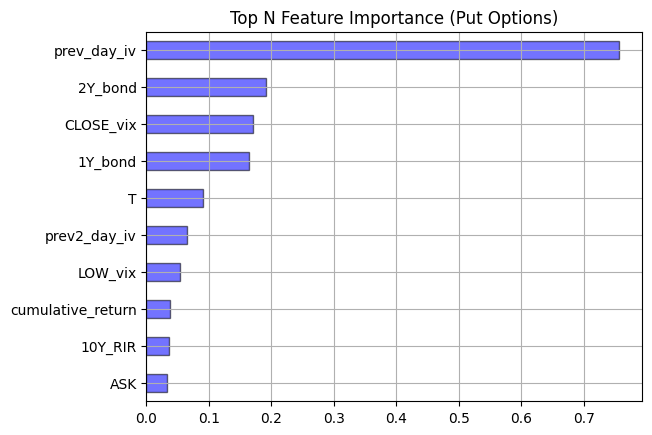

In [220]:
import matplotlib.pyplot as plt

def plot_feature_importance_barplot(sorted_importance, top_n=5):
    """
    Create a horizontal bar plot showing the top N feature importance.

    Parameters:
    sorted_importance (pd.DataFrame): Sorted feature importance DataFrame.
    top_n (int): Number of top features to plot.
    """
    # Select the top N features based on importance
    top_features = sorted_importance.head(top_n)

    # Sort the top N features by importance for plotting
    top_features = top_features.sort_values(by='importance', ascending=True)

    # Plot the top N feature importance
    plt.figure(figsize=(10, 6))
    ax = top_features.plot(kind='barh', x='feature', y='importance', color='blue', alpha=0.55, edgecolor='black', linewidth=1)
    
    # Remove the y-label
    ax.set_ylabel('')
    
    # Remove the legend
    ax.get_legend().remove()
    
    # Add grid and title
    plt.grid(True)
    ax.set_title('Top N Feature Importance (Put Options)')
    
    # plt.tight_layout()  # Optional: for better layout
    plt.show()

# Example usage: Plot the top 5 features from Put options data
plot_feature_importance_barplot(sorted_importance_c, top_n=10)


In [221]:
import pandas as pd
results_p = permutation_importance(best_model_put, combined_x_p, combined_y_p, n_repeats=1, random_state=42) #NEW
    # Get the feature importances and feature names
importance_p = results_p.importances_mean #NEW


# Get predictions
pred_y_p = best_model_put.predict(combined_x_p)

# Calculate mean squared error
mse_score = mean_squared_error(combined_y_p, pred_y_p)

# Assuming 'importance' is a list or array of feature importances
# Create a DataFrame with feature importance scores
feature_importance_networks = pd.DataFrame({
    'feature': combined_x_p.columns,  # Assuming feature names come from 'combined_x_p'
    'importance': importance_p  # Assuming 'importance' is a list or array of the same length as the number of features
})

# Print the MSE score (separately from the feature importances)
print(f"Mean Squared Error (MSE): {mse_score}")

# Sort by 'importance' in descending order
sorted_importance_p = feature_importance_networks.sort_values(by='importance', ascending=False)

# Display sorted feature importances
(sorted_importance_p)



2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 355us/step
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 407us/step
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 296us/step
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 232us/step
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 407us/step
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 268us/step
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 236us/step
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 357us/step
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 237us/step
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 272us/step
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 247us/step
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 372us/step
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 354us/step
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 562us/step
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 329us/step
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 287us/step
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 370us/step
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 337us/step
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 335us/step
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 271us/step
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 273us/step
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 333us/step
2281/2281 

,feature,importance
3,prev_day_iv,0.767611
17,2Y_bond,0.132207
0,T,0.073404
2,prev2_day_iv,0.055579
15,10Y_RIR,0.052455
10,cumulative_return,0.052418
20,HIGH_vix,0.044147
21,LOW_vix,0.041290
22,OPEN_vix,0.033465
8,PRC_actual,0.031785


<Figure size 1000x600 with 0 Axes>

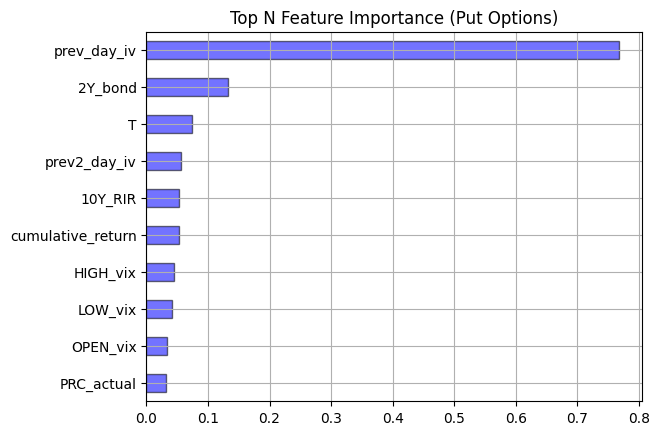

In [222]:
import matplotlib.pyplot as plt

def plot_feature_importance_barplot(sorted_importance, top_n=5):
    """
    Create a horizontal bar plot showing the top N feature importance.

    Parameters:
    sorted_importance (pd.DataFrame): Sorted feature importance DataFrame.
    top_n (int): Number of top features to plot.
    """
    # Select the top N features based on importance
    top_features = sorted_importance.head(top_n)

    # Sort the top N features by importance for plotting
    top_features = top_features.sort_values(by='importance', ascending=True)

    # Plot the top N feature importance
    plt.figure(figsize=(10, 6))
    ax = top_features.plot(kind='barh', x='feature', y='importance', color='blue', alpha=0.55, edgecolor='black', linewidth=1)
    
    # Remove the y-label
    ax.set_ylabel('')
    
    # Remove the legend
    ax.get_legend().remove()
    
    # Add grid and title
    plt.grid(True)
    ax.set_title('Top N Feature Importance (Put Options)')
    
    # plt.tight_layout()  # Optional: for better layout
    plt.show()

# Example usage: Plot the top 5 features from Put options data
plot_feature_importance_barplot(sorted_importance_p, top_n=10)


In [206]:
# sorted_importance_p

# Sort by importance
df_sorted = sorted_importance_p.sort_values(by='importance', ascending=False)

# Get the top 10 entries
top_10_df = df_sorted.head(10)

# Normalize the importance values to sum to 1 for the top 10 features
top_10_df['importance_normalized'] = top_10_df['importance'] / top_10_df['importance'].sum()

# Display the normalized DataFrame
top_10_df[['feature', 'importance', 'importance_normalized']]


/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_18772/1963729078.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_df['importance_normalized'] = top_10_df['importance'] / top_10_df['importance'].sum()


,feature,importance,importance_normalized
3,prev_day_iv,0.761074,0.600862
18,2Y_bond,0.100826,0.079601
21,HIGH_vix,0.079193,0.062522
11,cumulative_return,0.065490,0.051704
0,T,0.063354,0.050018
16,10Y_RIR,0.047051,0.037146
2,prev2_day_iv,0.044820,0.035385
23,OPEN_vix,0.039524,0.031204
17,1Y_bond,0.033716,0.026619
8,PRC_actual,0.031589,0.024939


In [207]:
# Sort by importance
df_sorted = sorted_importance_c.sort_values(by='importance', ascending=False)

# Get the top 10 entries
top_10_df = df_sorted.head(10)

# Normalize the importance values to sum to 1 for the top 10 features
top_10_df['importance_normalized'] = top_10_df['importance'] / top_10_df['importance'].sum()

# Display the normalized DataFrame
top_10_df[['feature', 'importance', 'importance_normalized']]

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_18772/3377667362.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_df['importance_normalized'] = top_10_df['importance'] / top_10_df['importance'].sum()


,feature,importance,importance_normalized
3,prev_day_iv,0.765249,0.485420
19,CLOSE_vix,0.287905,0.182627
18,2Y_bond,0.123037,0.078046
17,1Y_bond,0.094248,0.059784
22,LOW_vix,0.089782,0.056952
0,T,0.076999,0.048843
11,cumulative_return,0.045990,0.029173
2,prev2_day_iv,0.043765,0.027762
16,10Y_RIR,0.025941,0.016455
20,FF_rate,0.023552,0.014940


In [205]:
import pandas as pd

# Example data based on your image
data = {'feature': ['prev_day_iv', '2Y_bond', 'HIGH_vix', 'cumulative_return', 'T', 
                    '10Y_RIR', 'prev2_day_iv', 'OPEN_vix', '1Y_bond', 'PRC_actual'
                    ],
        'importance': [0.761074, 0.100826, 0.079193, 0.065490, 0.063354, 0.047051, 0.044820, 
                       0.039524, 0.033716, 0.031589]}

# Create DataFrame
df = pd.DataFrame(data)

# Normalize the importance values to sum to 1
df['importance_normalized'] = df['importance'] / df['importance'].sum()

# Display the normalized DataFrame
# import ace_tools as tools; tools.display_dataframe_to_user(name="Normalized Feature Importance", dataframe=df)
df

,feature,importance,importance_normalized
0,prev_day_iv,0.761074,0.600862
1,2Y_bond,0.100826,0.079601
2,HIGH_vix,0.079193,0.062522
3,cumulative_return,0.065490,0.051704
4,T,0.063354,0.050017
5,10Y_RIR,0.047051,0.037146
6,prev2_day_iv,0.044820,0.035385
7,OPEN_vix,0.039524,0.031204
8,1Y_bond,0.033716,0.026619
9,PRC_actual,0.031589,0.024939


In [222]:
# Reset the index and remove the old index by setting drop=True
sorted_importance_p_cleaned = sorted_importance_p.reset_index(drop=True)

# Display the cleaned DataFrame

# Print the DataFrame without showing the index
sorted_importance_p= (sorted_importance_p.to_string(index=False))

sorted_importance_p

'                     feature  importance\n                 prev_day_iv    0.769679\n                           T    0.077878\n           cumulative_return    0.067786\n                       BIDLO    0.050018\n                prev2_day_iv    0.045465\n                     10Y_RIR    0.043751\n                         BID    0.041074\n                  PRC_actual    0.040090\n                     2Y_bond    0.034504\n                     1Y_bond    0.031342\n                    OPEN_vix    0.026933\n                  gold_price    0.026808\n                       ASKHI    0.025359\n                   CLOSE_vix    0.025099\n                     LOW_vix    0.022857\n                  spread_vix    0.021125\n                         ASK    0.019284\n               volume_option    0.018687\n                    HIGH_vix    0.015443\n                        RETX    0.014120\n                         PRC    0.013984\n                         RET    0.013494\n               spread_option    0

In [109]:
sorted_importance_c

,feature,importance
0,prev_day_iv,0.936565
7,gold_price,0.497470
1,T,0.118749
8,reces_indi,0.101188
2,prev2_day_iv,0.092912
3,BIDLO,0.089504
4,OPEN_vix,0.079932
6,FF_rate,0.068652
5,hi-lo_stock,0.040914
9,spread_vix,0.013355


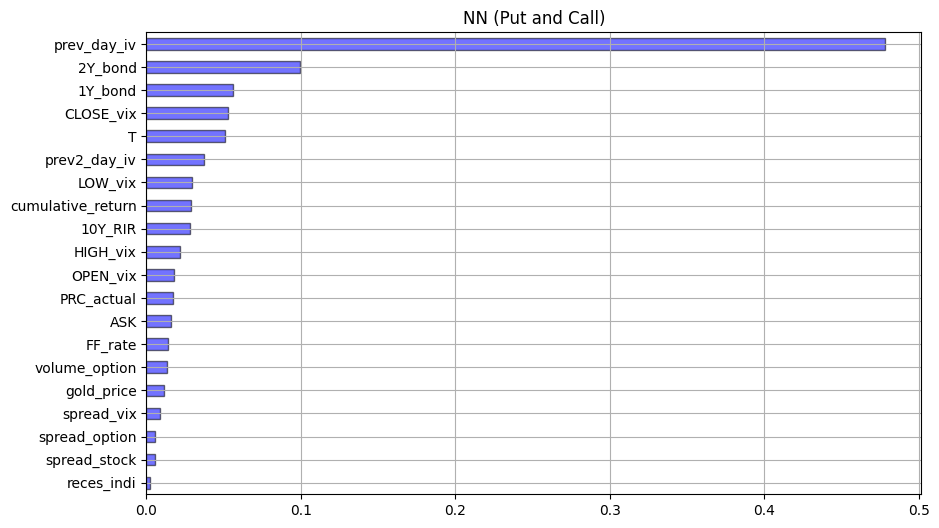

In [223]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_combined_feature_importance_barplot(sorted_importance_c, sorted_importance_p, top_n=5):
    """
    Create a horizontal bar plot showing the top N normalized average feature importance from both Call and Put options.

    Parameters:
    sorted_importance_c (pd.DataFrame): Sorted feature importance DataFrame for Call options.
    sorted_importance_p (pd.DataFrame): Sorted feature importance DataFrame for Put options.
    top_n (int): Number of top features to plot.
    """
    # Merge Call and Put DataFrames on feature name to get both importance values
    combined_importance = pd.concat(
        [sorted_importance_c.set_index('feature'), sorted_importance_p.set_index('feature')], 
        axis=1, keys=["importance_call", "importance_put"]
    ).fillna(0).reset_index()

    # print(combined_importance)
    
    # Normalize the importance values to sum to 1 for both Call and Put
    combined_importance['importance_call'] /= combined_importance['importance_call'].sum()
    combined_importance['importance_put'] /= combined_importance['importance_put'].sum()

    # Calculate the average normalized importance
    combined_importance['average_importance'] = combined_importance[['importance_call', 'importance_put']].mean(axis=1)
    
    # Sort by the average importance and select the top N features
    top_features = combined_importance.sort_values(by='average_importance', ascending=False).head(top_n)

    # Plot the top N normalized average feature importance with a larger size
    # plt.figure(figsize=((10, 6)))  # Adjust this as needed for the correct aspect ratio
    fig, ax = plt.subplots(figsize=(10, 6))

    ax = top_features.sort_values(by='average_importance', ascending=True).plot(
        kind='barh', 
        x='feature', 
        y='average_importance', 
        color='blue', 
        alpha=0.55, 
        edgecolor='black', 
        linewidth=1,
        ax=ax  # Use the ax from fig
    )
    
    # Remove the y-label
    ax.set_ylabel('')
    
    # Remove the legend
    ax.get_legend().remove()
    
    # Add grid and title
    plt.grid(True)
    ax.set_title('NN (Put and Call)')
    
    plt.show()

    return combined_importance

# Example usage: Plot the top 5 normalized features from combined Call and Put options data
combfeat = plot_combined_feature_importance_barplot(sorted_importance_c, sorted_importance_p, top_n=20)


In [225]:
# Sort the DataFrame by 'average_importance' in descending order
sorted_combfeat = combfeat.sort_values(by=('average_importance', ''), ascending=False)

# Display the sorted DataFrame
sorted_combfeat

,feature,importance_call,importance_put,average_importance
,,importance,importance,
0,prev_day_iv,0.426052,0.529666,0.477859
1,2Y_bond,0.107958,0.091225,0.099592
3,1Y_bond,0.092431,0.019163,0.055797
2,CLOSE_vix,0.095909,0.010210,0.053060
4,T,0.051365,0.050650,0.051007
5,prev2_day_iv,0.036310,0.038351,0.037330
6,LOW_vix,0.029910,0.028491,0.029200
7,cumulative_return,0.021382,0.036170,0.028776
8,10Y_RIR,0.020152,0.036195,0.028173


In [188]:

# # y_oos = best_model_put.predict(test_x_p)


# # predictions = [mean_squared_error(combined_y_p, pred_y), y_oos]

# pred_y = best_model_put.predict(combined_x_p)
# feature_importance_networks = [mean_squared_error(combined_y_p, pred_y), importance]
# sorted_importance = feature_importance_networks.sort_values(by='score', ascending=True) #NEW

2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 301us/step


AttributeError: 'list' object has no attribute 'sort_values'

In [109]:
best_model_put = train_and_evaluate(train_x_p, train_y_p, combined_x_p, combined_y_p, test_x_p, test_y_p)

Running hyperparameter tuning with validation data...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Epoch 1/50
Epoch 1/50
Epoch 1/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 383us/step - loss: 0.2765 - mse: 0.2765
Epoch 2/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 384us/step - loss: 0.4559 - mse: 0.4559
Epoch 2/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 383us/step - loss: 0.1565 - mse: 0.1565
Epoch 2/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 376us/step - loss: 0.0992 - mse: 0.0992
Epoch 3/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 376us/step - loss: 0.1022 - mse: 0.1022
Epoch 3/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 379us/step - loss: 0.0407 - mse: 0.0407
Epoch 3/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 463us/step - loss: 0.0734 - mse: 0.0734
Epoch 4/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step - loss: 0.0744 - mse: 0.0744
Epoch 4/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 463us/step - loss: 0.0276 - mse: 0.0276
Epoch 4/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 374us/step - loss: 0.0609 - mse: 0.0609
Epoch 5/50
1521

In [98]:
# # Preprocess my data 
# # First standardize the data
# scaler = StandardScaler()
# scaler.fit(train_x_c)
# train_x_c = scaler.transform(train_x_c)
# test_x_c = scaler.transform(test_x_c)


In [99]:

# Best Parameters_c: {'batch_size': 32, 'epochs': 50, 'model_dropout_rate': 0, 'modellayers': 1, 'model_neurons': 8}


# Define the model function with variable neurons, layers, and dropout rate
def create_model(input_dim, neurons, layers, dropout_rate):
    model = Sequential()
    # Input layer using Input instead of input_dim argument
    model.add(Input(shape=(input_dim,)))  # Define the input shape explicitly

    # First hidden layer
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))  # Dropout layer after the first hidden layer

    # Additional hidden layers
    for _ in range(layers - 1):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='linear'))  # Output layer for regression (linear)

    # Compile the model
    model.compile(optimizer=RMSprop(learning_rate=0.01),
                  loss='mean_squared_error',
                  metrics=['mse'])
    return model

model_p = create_model(combined_x_p.shape[1], 8, 1, 0.5)

# Retrain the model on the combined training and validation set
model_p.fit(combined_x_p, combined_y_p, batch_size=32, epochs=50, verbose=1)

# Make predictions on the test set
predictions_p = model_p.predict(test_x_p)

# Calculate R² and RMSE for the best model
r2_c = r2_score(test_y_p, predictions_p)
rmse_c = np.sqrt(mean_squared_error(test_y_p, predictions_p))

# Print the results
print(f"R²: {r2_c:.4f}")
print(f"RMSE: {rmse_c:.4f}")

Epoch 1/50
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step - loss: 0.2191 - mse: 0.2191
Epoch 2/50
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 257us/step - loss: 0.0680 - mse: 0.0680
Epoch 3/50
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 253us/step - loss: 0.0672 - mse: 0.0672
Epoch 4/50
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 258us/step - loss: 0.0690 - mse: 0.0690
Epoch 5/50
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 259us/step - loss: 0.0680 - mse: 0.0680
Epoch 6/50
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 259us/step - loss: 0.0681 - mse: 0.0681
Epoch 7/50
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 260us/step - loss: 0.0690 - mse: 0.0690
Epoch 8/50
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 287us/step - loss: 0.0689 - mse: 0.0689
Epoch 9/50
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 268us/step - loss: 0.0665 - mse: 0.0665
Epoch 10/50
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 260us/step - loss: 0.0680 - mse: 0.0680
Epoch 11/50
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 257us/step - loss: 0.0689 - mse: 0.0689
Epoch 12/50
2281/2281 ━━━━━━━━━━━━━━━━━━━━ 1s 255us/step - loss

In [95]:
import numpy as nq
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import RMSprop
from sklearn.metrics import r2_score, mean_squared_error

# Define the model function with variable neurons, layers, and dropout rate
def create_model(input_dim, neurons, layers, dropout_rate):
    model = Sequential()
    # Input layer using Input instead of input_dim argument
    model.add(Input(shape=(input_dim,)))  # Define the input shape explicitly

    # First hidden layer
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))  # Dropout layer after the first hidden layer

    # Additional hidden layers
    for _ in range(layers - 1):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='linear'))  # Output layer for regression (linear)

    # Compile the model
    model.compile(optimizer=RMSprop(learning_rate=0.01),
                  loss='mean_squared_error',
                  metrics=['mse'])
    return model

def evaluate_model(model, combined_x, combined_y, test_x, test_y, batch_size, epochs):
    # Retrain the model on the combined training and validation set
    model.fit(combined_x, combined_y, batch_size=batch_size, epochs=epochs, verbose=1)

    # Make predictions on the test set
    predictions = model.predict(test_x)

    # Calculate R² and RMSE for the best model
    r2 = r2_score(test_y, predictions)
    rmse = np.sqrt(mean_squared_error(test_y, predictions))

    # Print the results
    print(f"R²: {r2:.,f}")
    print(f"RMSE: {rmse:.4f}")

# Example usage for call options
# print("Evaluating Call Options Model:")
# model_c = create_model(combined_x_c.shape[1], neurons=8, layers=3, dropout_rate=0.2)
# evaluate_model(model_c, combined_x_c, combined_y_c, test_x_c, test_y_c, batch_size=32, epochs=50)

# Example usage for put options
print("Evaluating Put Options Model:")
model_p = create_model(combined_x_p.shape[1], neurons=8, layers=1, dropout_rate=0.5)
evaluate_model(model_p, combined_x_p, combined_y_p, test_x_p, test_y_p, batch_size=32, epochs=50)



Evaluating Call Options Model:
Epoch 1/50
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 368us/step - loss: 0.0913 - mse: 0.0913
Epoch 2/50
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 319us/step - loss: 0.0508 - mse: 0.0508
Epoch 3/50
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 318us/step - loss: 0.0479 - mse: 0.0479
Epoch 4/50
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 312us/step - loss: 0.0478 - mse: 0.0478
Epoch 5/50
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 311us/step - loss: 0.0486 - mse: 0.0486
Epoch 6/50
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 309us/step - loss: 0.0481 - mse: 0.0481
Epoch 7/50
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 339us/step - loss: 0.0470 - mse: 0.0470
Epoch 8/50
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 315us/step - loss: 0.0463 - mse: 0.0463
Epoch 9/50
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 314us/step - loss: 0.0468 - mse: 0.0468
Epoch 10/50
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 353us/step - loss: 0.0459 - mse: 0.0459
Epoch 11/50
2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 386us/step - loss: 0.0467 - mse: 0.0467
Epoch 12/50
2261/2261 ━━━━━━━━━━

In [96]:
combined_x_p.head(5)

,T,moneyness,prev2_day_iv,prev_day_iv,5_day_rolling_return_stock,ASK,ASKHI,BID,BIDLO,PRC,...,1Y_bond,2Y_bond,CLOSE_vix,FF_rate,HIGH_vix,LOW_vix,OPEN_vix,gold_price,reces_indi,spread_vix
0,-0.862489,-1.599060,-1.565542,-0.215265,-0.286276,-0.56898,-0.56926,-0.56901,-0.567166,-0.568991,...,1.371916,1.469739,0.476238,1.12461,0.475155,0.662651,0.674867,-1.353864,-0.709827,-0.133918
1,-0.862489,-1.348787,-1.565542,-0.243882,-0.286276,-0.56898,-0.56926,-0.56901,-0.567166,-0.568991,...,1.371916,1.469739,0.476238,1.12461,0.475155,0.662651,0.674867,-1.353864,-0.709827,-0.133918
2,-0.862489,-1.099920,-1.565542,-0.272954,-0.286276,-0.56898,-0.56926,-0.56901,-0.567166,-0.568991,...,1.371916,1.469739,0.476238,1.12461,0.475155,0.662651,0.674867,-1.353864,-0.709827,-0.133918
3,-0.862489,-0.853865,-1.565542,-0.301999,-0.286276,-0.56898,-0.56926,-0.56901,-0.567166,-0.568991,...,1.371916,1.469739,0.476238,1.12461,0.475155,0.662651,0.674867,-1.353864,-0.709827,-0.133918
4,-0.862489,-0.242243,-1.565542,-0.349271,-0.286276,-0.56898,-0.56926,-0.56901,-0.567166,-0.568991,...,1.371916,1.469739,0.476238,1.12461,0.475155,0.662651,0.674867,-1.353864,-0.709827,-0.133918


In [50]:
predictions_c

array([[-0.6547025 ],
       [-0.6540263 ],
       [-0.64889556],
       ...,
       [ 0.829493  ],
       [ 0.90898424],
       [ 0.98446095]], dtype=float32)

In [7]:
# import keras.backend as K
# from keras import regularizers
# from tensorflow import keras
# from keras.layers import Dense
# from keras.models import Sequential, load_model
# from sklearn.model_selection import GridSearchCV
# from keras.wrappers.scikit_learn import KerasRegressor
# from keras.optimizers import RMSprop
# from keras.optimizers import Adam

# # define the model
# def create_model(bias, activity):
#   model = Sequential()
#   model.add(Dense(units=32,
#                   activation='relu',
#                   input_dim= train_x.shape[1],
#                   # # kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5),
#                   bias_regularizer= regularizers.L2(bias),
#                   activity_regularizer= regularizers.L2(activity)
#                   ))
#   model.add(Dense(units=32, activation= 'relu',
#                   bias_regularizer=regularizers.L2(bias),
#                   activity_regularizer=regularizers.L2(activity) #activation
#                   ))
#   model.add(Dense(units=1, activation= 'linear')) #miss linear

#   # compile the model
#   model.compile(optimizer= RMSprop(learning_rate=0.01), #'rmsprop',#Optimizer_trial,
#                 loss= 'mean_squared_error',
#                 metrics=['mse'])
#   return model

# # Wrapping the model in KerasRegressor
# model = KerasRegressor(build_fn=create_model, verbose=0)

# # Define the parameter grid for trials
# param_grid = {
#     'neurons': [8, 16, 32, 64],   # Number of neurons in each hidden layer
#     'layers': [1, 2, 3, 4],       # Number of hidden layers
#     'dropout_rate': [0, 0.2, 0.5], # Dropout rate
#     'batch_size': [32, 64],       # Batch size for training
#     'epochs': [50, 100],          # Number of epochs
# }



In [8]:
# import numpy as np
# import keras.backend as K
# from keras import regularizers
# from keras.layers import Dense, Dropout
# from keras.models import Sequential
# from sklearn.model_selection import GridSearchCV, train_test_split
# from sklearn.metrics import mean_squared_error, r2_score
# from keras.wrappers.scikit_learn import KerasRegressor
# from keras.optimizers import RMSprop

# # Define the model function with variable neurons, layers, and dropout rate
# def create_model(neurons=32, layers=1, dropout_rate=0.0, bias=0.01, activity=0.01):
#     model = Sequential()
#     # Input layer (first hidden layer)
#     model.add(Dense(neurons, activation='relu', input_dim=train_x.shape[1],
#                     bias_regularizer=regularizers.L2(bias),
#                     activity_regularizer=regularizers.L2(activity)))
#     model.add(Dropout(dropout_rate))  # Dropout layer after the first hidden layer

#     # Additional hidden layers
#     for _ in range(layers - 1):
#         model.add(Dense(neurons, activation='relu',
#                         bias_regularizer=regularizers.L2(bias),
#                         activity_regularizer=regularizers.L2(activity)))
#         model.add(Dropout(dropout_rate))

#     # Output layer
#     model.add(Dense(1, activation='linear'))  # Output layer for regression (linear)

#     # Compile the model
#     model.compile(optimizer=RMSprop(learning_rate=0.01),
#                   loss='mean_squared_error',
#                   metrics=['mse'])
#     return model

# # Wrapping the model in KerasRegressor
# model = KerasRegressor(build_fn=create_model, verbose=0)

# # Define the parameter grid for trials
# param_grid = {
#     'neurons': [8, 16, 32, 64],   # Number of neurons in each hidden layer
#     'layers': [1, 2, 3, 4],       # Number of hidden layers
#     'dropout_rate': [0, 0.2, 0.5], # Dropout rate
#     'batch_size': [32, 64],       # Batch size for training
#     'epochs': [50, 100],          # Number of epochs
# }

# # Initialize GridSearchCV with the model, parameter grid, and scoring
# grid_search = GridSearchCV(estimator=model,
#                            param_grid=param_grid,
#                            scoring='neg_mean_squared_error',  # Scoring based on MSE
#                            cv=3,  # 3-fold cross-validation
#                            verbose=1)  # Verbose for tracking progress

# # Run the grid search
# grid_search.fit(train_x, train_y)

# # Get the best estimator and parameters
# best_model = grid_search.best_estimator_
# best_params = grid_search.best_params_

# # Make predictions using the best model
# predictions = best_model.predict(test_x)

# # Calculate R² and RMSE for the best model
# r2 = r2_score(test_y, predictions)
# rmse = np.sqrt(mean_squared_error(test_y, predictions))

# # Print the results
# print(f"Best Parameters: {best_params}")
# print(f"R²: {r2:.4f}")
# print(f"RMSE: {rmse:.4f}")


In [9]:
# import tensorflow as tf
# print(tf.__version__)
# import time
# import itertools
# import numpy as np
# import pandas as pd
# from sklearn.metrics import mean_squared_error, r2_score
# from keras_tuner import KerasRegressor
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import Adam
# # from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# # from keras_tuner import KerasRegressor
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# from tensorflow.keras.callbacks import EarlyStopping

# def create_model(hidden_layers=1, units=64, activation='relu', learning_rate=0.001):
#     """
#     Function to create a Keras Sequential model with the given hyperparameters.
#     """
#     model = Sequential()
#     model.add(Dense(units=units, activation=activation, input_dim=X_train.shape[1]))
    
#     for _ in range(hidden_layers - 1):
#         model.add(Dense(units=units, activation=activation))
        
#     model.add(Dense(1))  # Output layer

#     optimizer = Adam(learning_rate=learning_rate)
#     model.compile(optimizer=optimizer, loss='mean_squared_error')
    
#     return model

# def prepare_data_with_gridsearch_nn(train_data, validate_data, test_data, option_type, verbose=True):
#     """
#     Prepare the data, perform hyperparameter tuning using Year 1 (train) and Year 2 (validation),
#     retrain the model on Year 1 + Year 2, and evaluate on Year 3 (test) for Neural Networks.
    
#     Parameters:
#     train_data (pd.DataFrame): The training dataset (Year 1).
#     validate_data (pd.DataFrame): The validation dataset (Year 2).
#     test_data (pd.DataFrame): The testing dataset (Year 3).
#     option_type (str): Call or Put option type for labeling the print output.
#     verbose (bool): If True, prints progress information for hyperparameter tuning.
#     """
#     # Prepare the train, validation, and test data
#     X_train = train_data.drop(columns=['impl_volatility', 'date', 'Ticker', 'cp_flag'])  # Training features (Year 1)
#     y_train = train_data['impl_volatility']  # Training target (Year 1)

#     X_validate = validate_data.drop(columns=['impl_volatility', 'date', 'Ticker', 'cp_flag'])  # Validation features (Year 2)
#     y_validate = validate_data['impl_volatility']  # Validation target (Year 2)
    
#     X_test = test_data.drop(columns=['impl_volatility', 'date', 'Ticker', 'cp_flag'])  # Test features (Year 3)
#     y_test = test_data['impl_volatility']  # Test target (Year 3)

#     # Define the hyperparameter grid for NN
#     param_grid = {
#         'hidden_layers': [1, 2, 3],                # Number of hidden layers
#         'units': [32, 64, 128],                    # Number of units per layer
#         'activation': ['relu', 'tanh'],            # Activation function
#         'learning_rate': [0.001, 0.01],            # Learning rate for Adam optimizer
#         'batch_size': [32, 64],                    # Batch size
#         'epochs': [50, 100],                       # Number of epochs
#     }

#     # Generate all combinations of hyperparameters
#     param_combinations = list(itertools.product(
#         param_grid['hidden_layers'], 
#         param_grid['units'], 
#         param_grid['activation'], 
#         param_grid['learning_rate'], 
#         param_grid['batch_size'], 
#         param_grid['epochs']
#     ))

#     total_combinations = len(param_combinations)
    
#     # Initialize variables to store the best model and best score
#     best_rmse_val = np.inf
#     best_params = None
#     best_nn_model = None

#     print(f"Running manual hyperparameter tuning for {option_type} Options with Neural Networks...")
    
#     # Iterate over all hyperparameter combinations with progress tracking
#     for i, (hidden_layers, units, activation, learning_rate, batch_size, epochs) in enumerate(param_combinations):
#         start_time = time.time()
        
#         # Create the Keras model with the current set of hyperparameters
#         model = create_model(hidden_layers=hidden_layers, units=units, activation=activation, learning_rate=learning_rate)

#         # Early stopping to prevent overfitting
#         early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#         # Train the model on the training data (Year 1)
#         history = model.fit(X_train, y_train, 
#                             validation_data=(X_validate, y_validate),
#                             batch_size=batch_size, 
#                             epochs=epochs, 
#                             verbose=0, 
#                             callbacks=[early_stopping])

#         # Validate the model on the validation data (Year 2)
#         y_val_pred = model.predict(X_validate)
#         rmse_val = np.sqrt(mean_squared_error(y_validate, y_val_pred))

#         # Track the best performing hyperparameters based on validation RMSE
#         if rmse_val < best_rmse_val:
#             best_rmse_val = rmse_val
#             best_params = {
#                 'hidden_layers': hidden_layers,
#                 'units': units,
#                 'activation': activation,
#                 'learning_rate': learning_rate,
#                 'batch_size': batch_size,
#                 'epochs': epochs
#             }
#             best_nn_model = model

#         # Verbose output to track progress
#         if verbose:
#             elapsed_time = time.time() - start_time
#             print(f"Combination {i + 1}/{total_combinations} completed in {elapsed_time:.2f} seconds.")
#             print(f"Current RMSE (Validation): {rmse_val:.4f}")
#             print(f"Best RMSE so far: {best_rmse_val:.4f}")
    
#     print(f"\nBest Parameters for {option_type} Options with Neural Networks: {best_params}")
    
#     # Retrain the model on combined Year 1 (train) and Year 2 (validation)
#     print("Retraining the model on Year 1 and Year 2 combined...")
#     X_combined = pd.concat([X_train, X_validate])
#     y_combined = pd.concat([y_train, y_validate])
#     best_nn_model.fit(X_combined, y_combined, batch_size=best_params['batch_size'], epochs=best_params['epochs'], verbose=0)

#     # In-sample (combined Year 1 + Year 2) predictions
#     y_combined_pred = best_nn_model.predict(X_combined)

#     # Evaluate In-Sample Performance (on combined Year 1 + Year 2)
#     rmse_combined = np.sqrt(mean_squared_error(y_combined, y_combined_pred))
#     r2_combined = r2_score(y_combined, y_combined_pred)
    
#     print(f"\nIn-Sample Performance for {option_type} Options (Year 1 + Year 2):")
#     print(f"RMSE (Training + Validation): {rmse_combined:.4f}")
#     print(f"R² (Training + Validation): {r2_combined:.4f}")

#     # After retraining, evaluate performance on the test data (Year 3)
#     y_test_pred = best_nn_model.predict(X_test)

#     # Evaluate Out-of-Sample Performance (on Test Data)
#     rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
#     r2_test = r2_score(y_test, y_test_pred)

#     # Print the final results
#     print(f"\nPerformance on Test Data (Year 3) for {option_type} Options:")
#     print(f"Out-of-Sample RMSE (Test): {rmse_test:.4f}")
#     print(f"Out-of-Sample R² (Test): {r2_test:.4f}")


# # Call the function for Call options data
# prepare_data_with_gridsearch_nn(data_train_c, data_validate_c, data_test_c, 'Call')

# # Call the function for Put options data
# prepare_data_with_gridsearch_nn(data_train_p, data_validate_p, data_test_p, 'Put')
